# Data recovery, analysis, and plotting

Software = maccor
Folder path = C:\Users\sasch\Desktop\Full_Pouch_cells\Full_cells_with_components from_08.12.2022
Filename =  SK_BM_K5_SE7 - 081.txt
C_rate_list = ['C_20', 'C_20', 'C_10', 'C_20', 'C_10', 'C_5', 'C_2']
Cycle(s) per formation = 3
formation =  1
Cycle(s) per C_rate = 1
C_rate_list for life cycle test = ['C_2']
Cycles per C-rate for life cycle test = [1000]
Points per linear interpolation = 100
Savgol filter - windows length = 99
Savgol filter - polynomial order = 2
Normalization mass = 4.3505 mg
ELab experiment name =  nan
ELab user name =  nan
ELab token =  0
Formation accounted for charge
Formation accounted for discharge


C:\Users\sasch\anaconda3\lib\site-packages\numpy\lib\function_base.py:1073: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
C:\Users\sasch\anaconda3\lib\site-packages\numpy\lib\function_base.py:1073: RuntimeWarning: invalid value encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
C:\Users\sasch\anaconda3\lib\site-packages\numpy\lib\function_base.py:1074: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
C:\Users\sasch\anaconda3\lib\site-packages\numpy\lib\function_base.py:1074: RuntimeWarning: invalid value encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
C:\Users\sasch\anaconda3\lib\site-packages\numpy\lib\function_base.py:1075: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
C:\Users\sasch\anaconda3\lib\site-packages\numpy\lib\function_base.py:1075: RuntimeWarning: invalid value encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
C:\Us

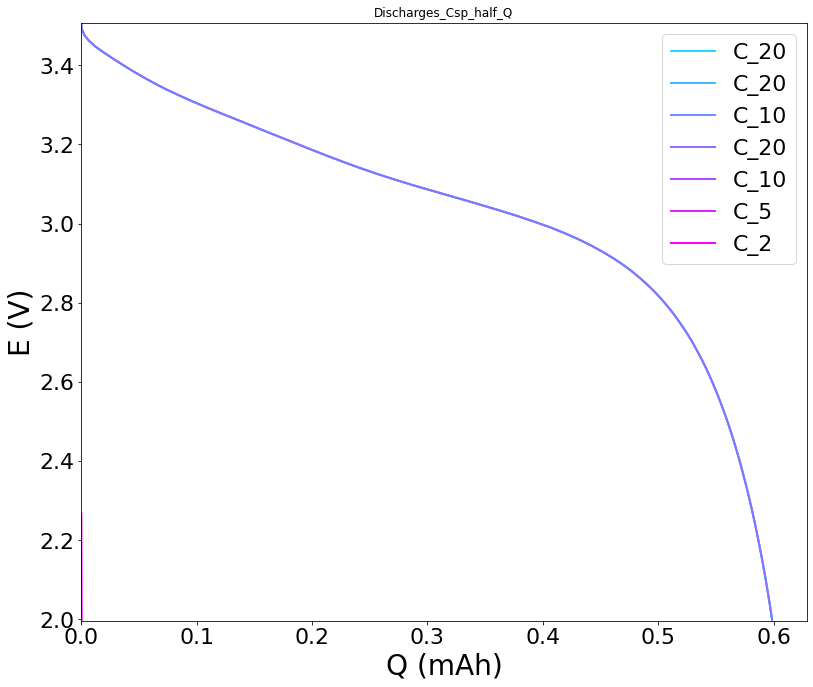

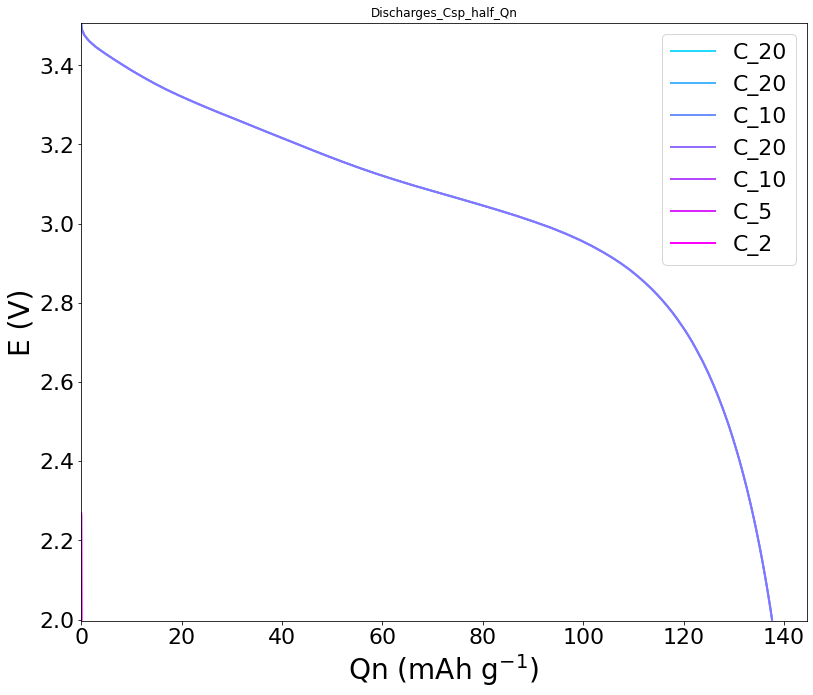

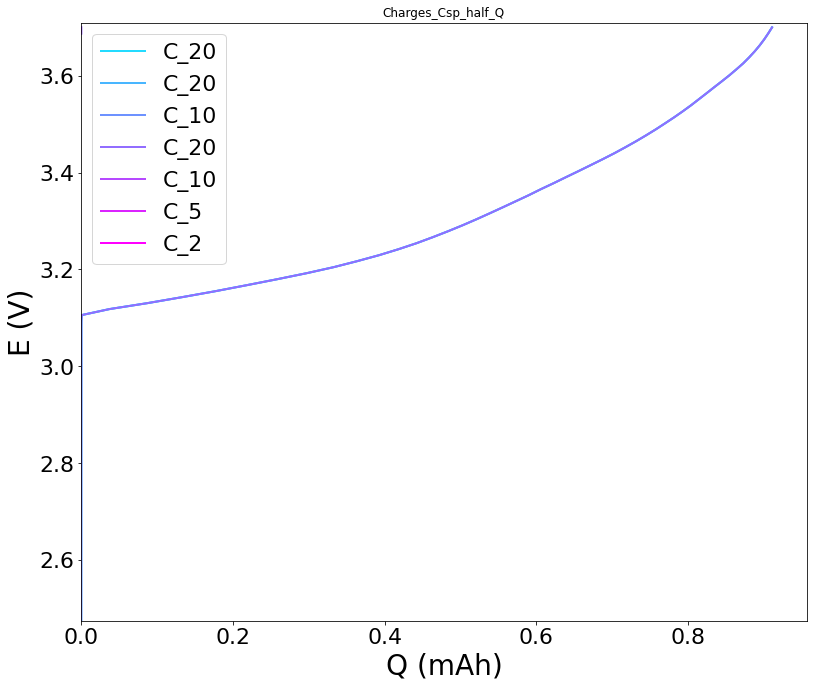

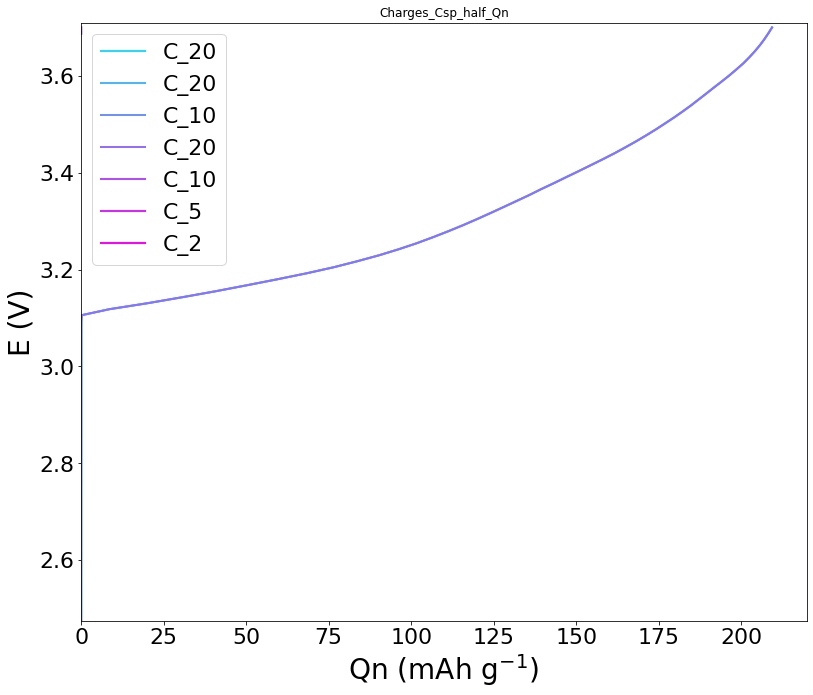

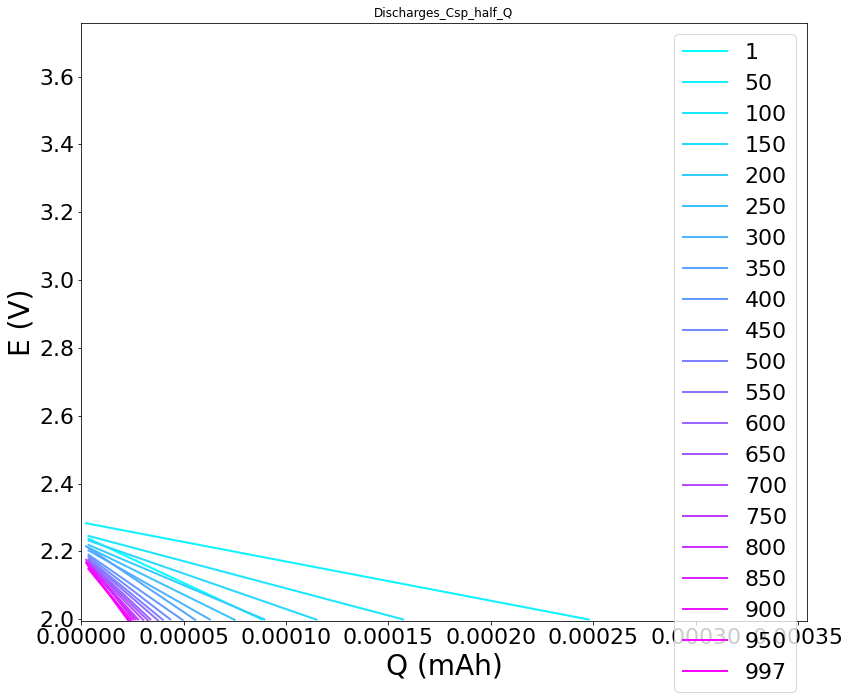

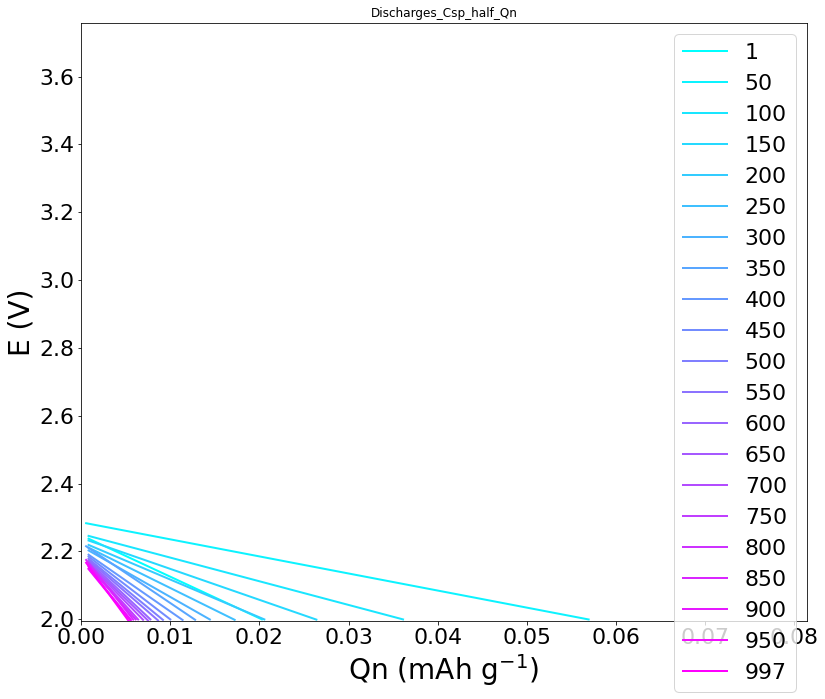

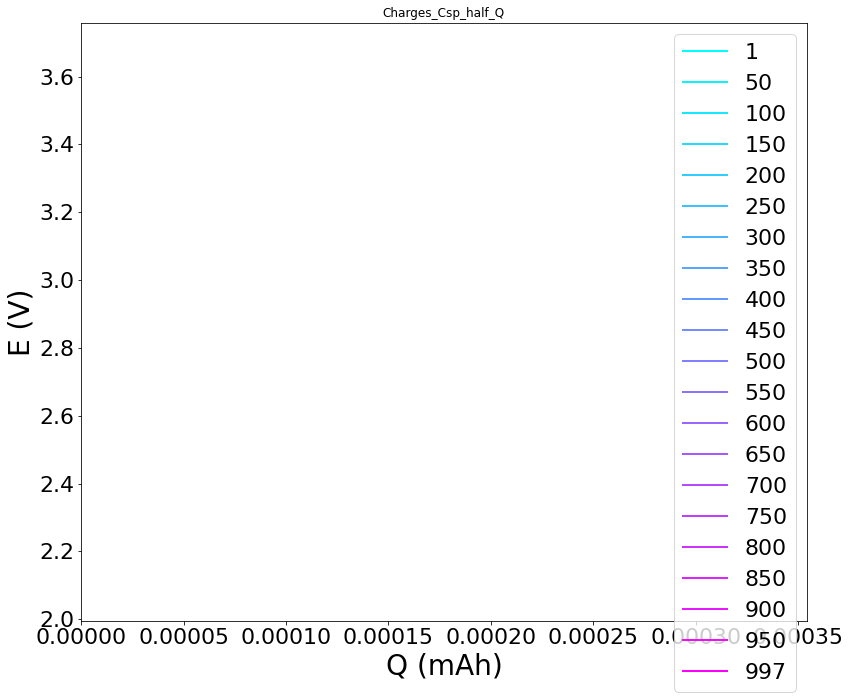

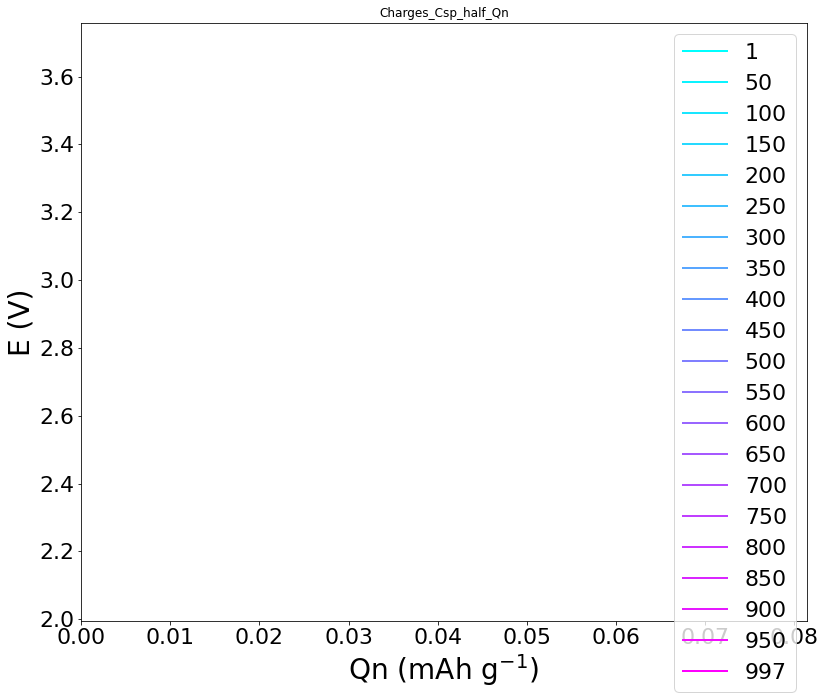

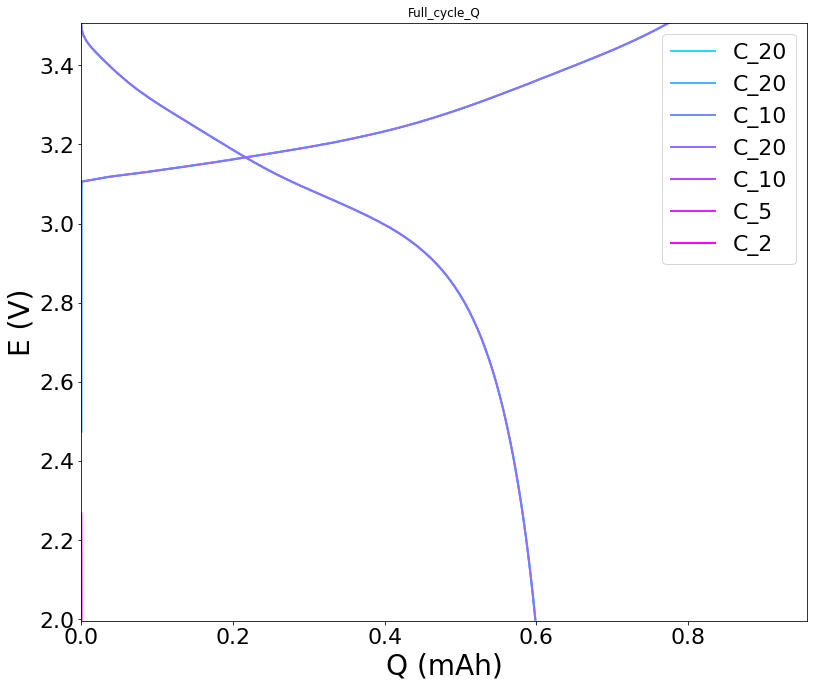

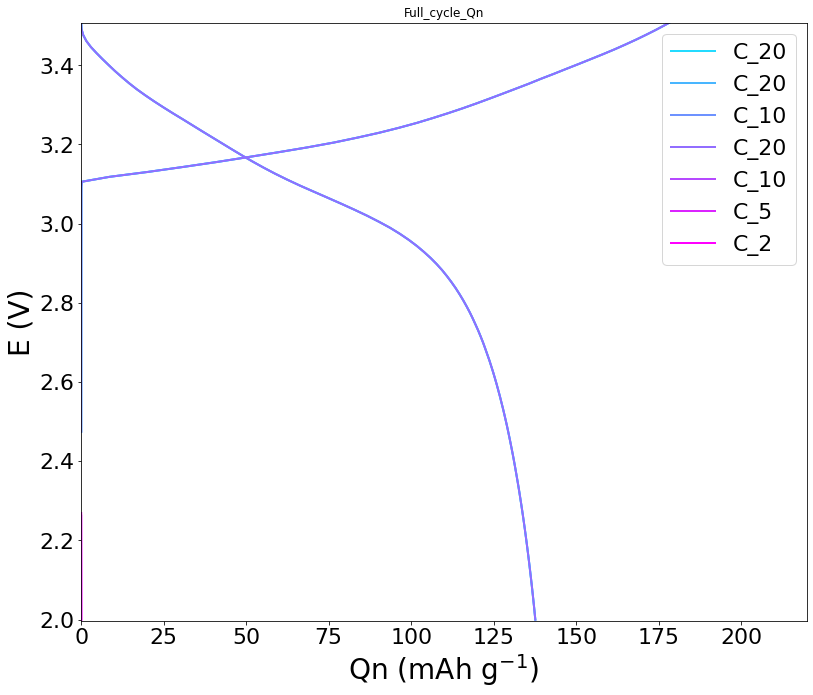

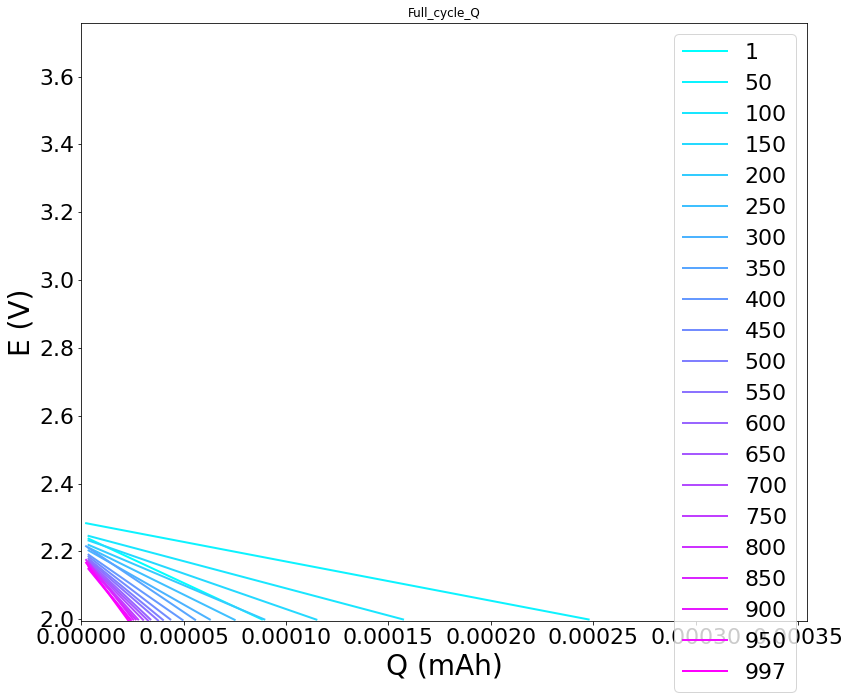

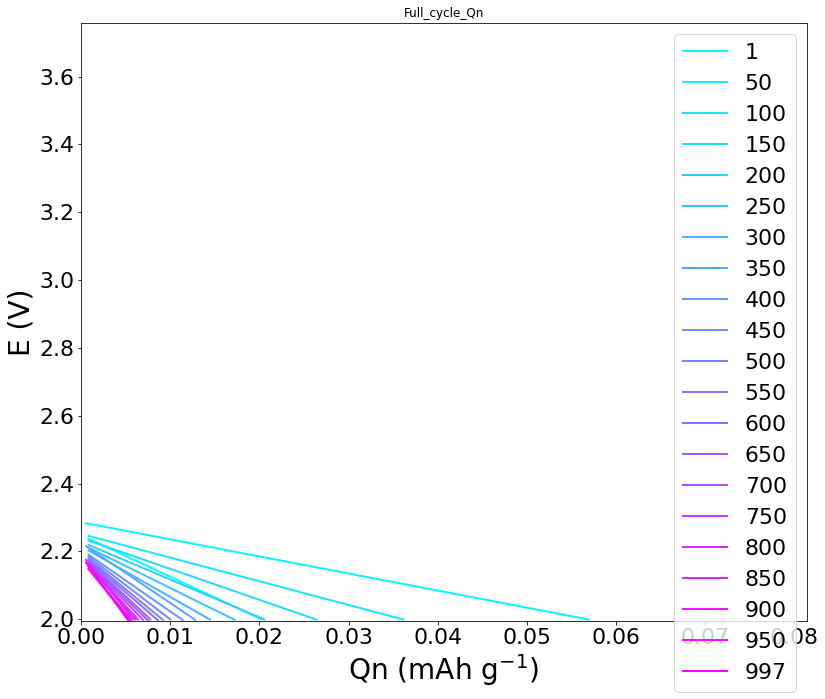

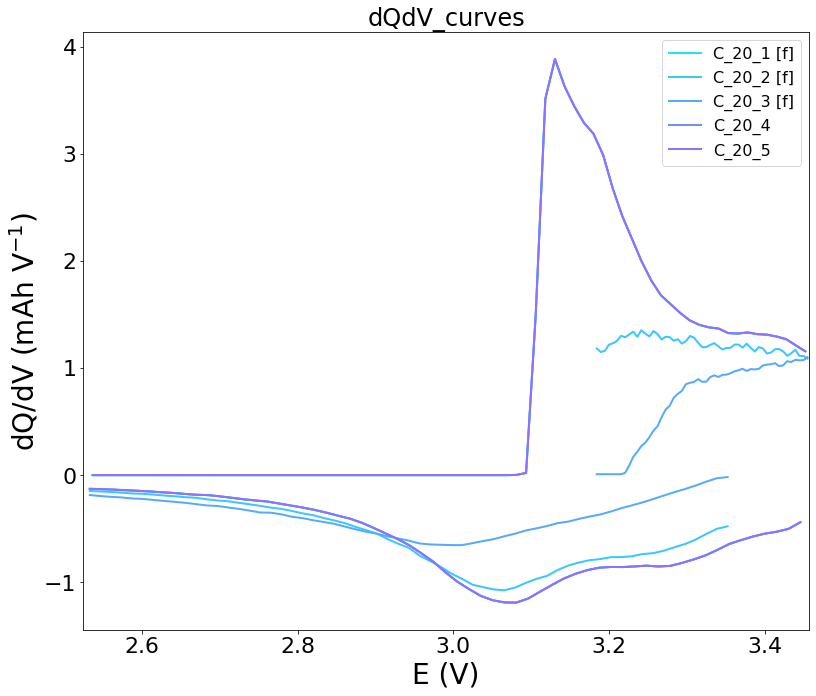

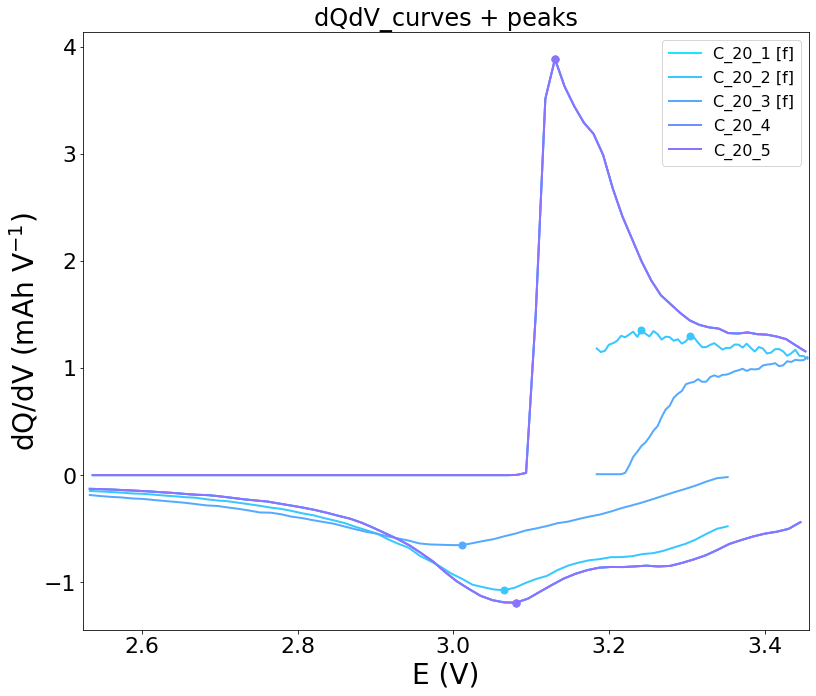

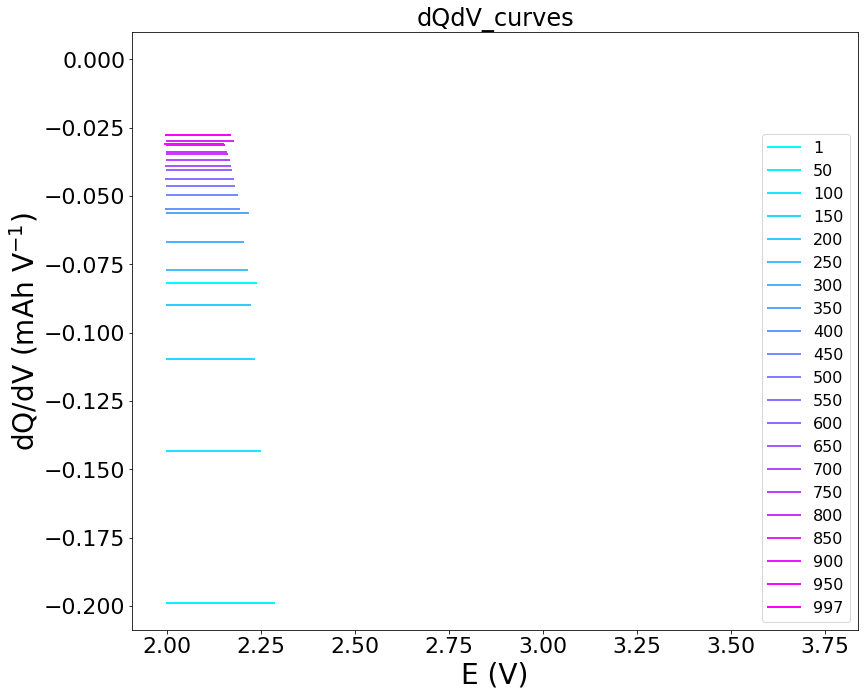

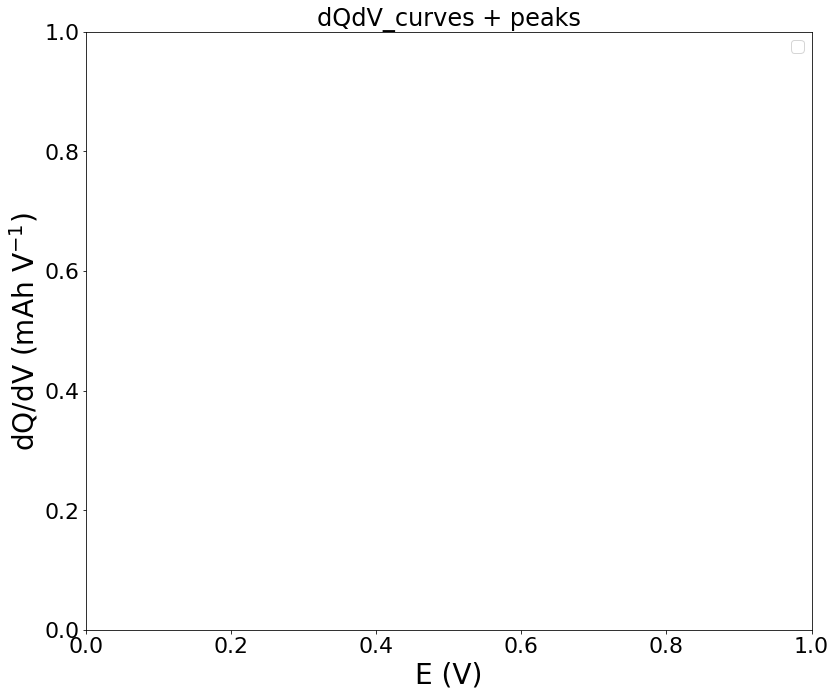

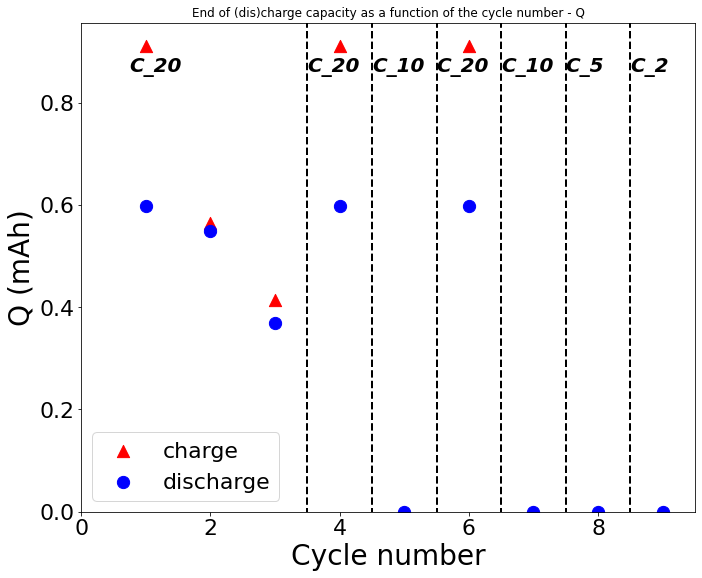

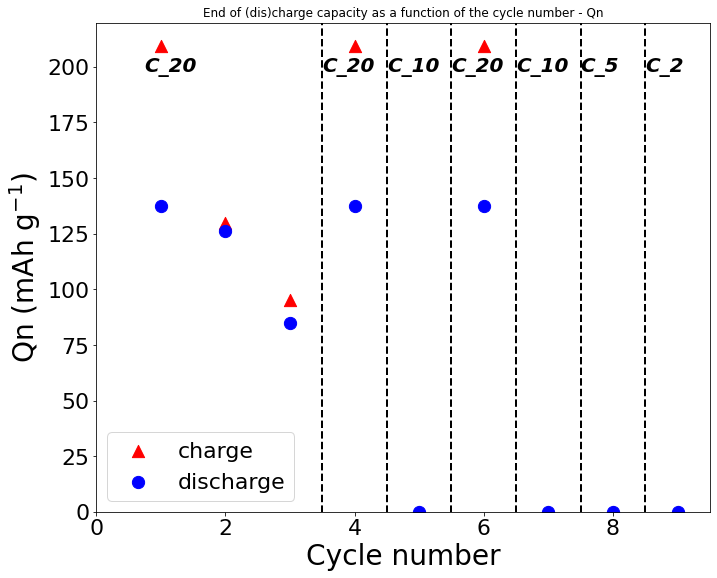

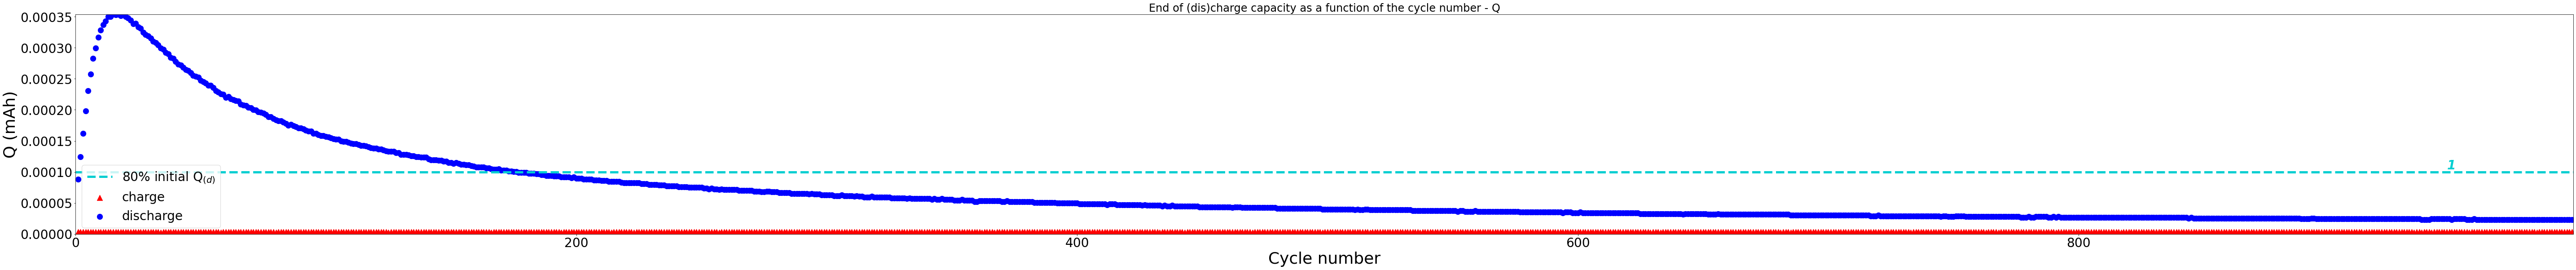

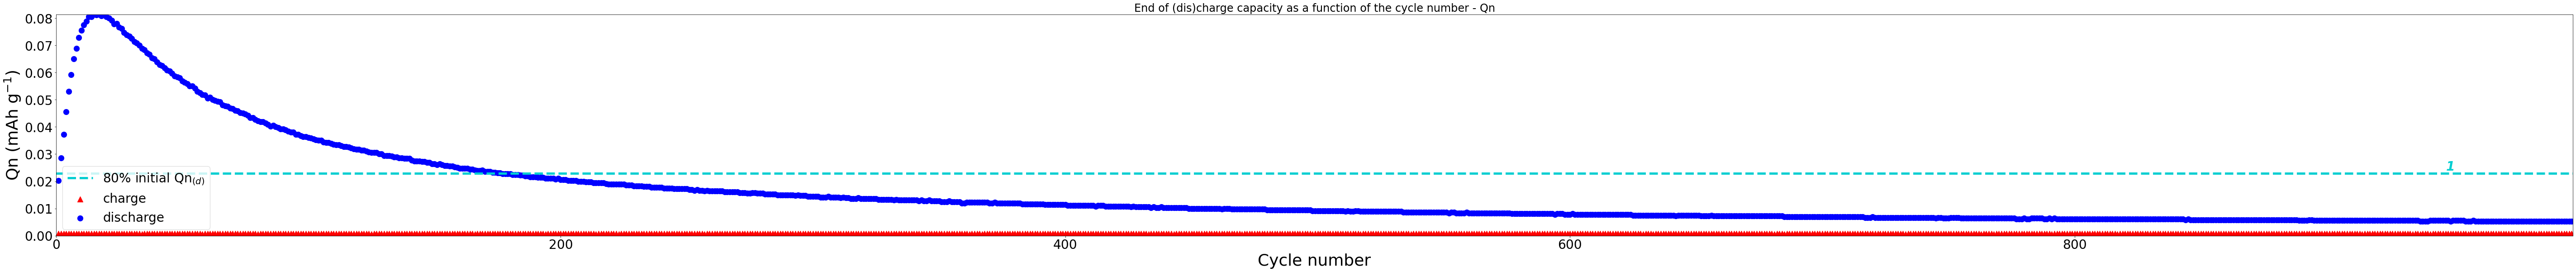

In [22]:
import pandas as pd
import string
from glob import glob
import numpy as np
import os, fnmatch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import statistics
import codecs
import math
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter, find_peaks
from ipywidgets import interact, interactive, fixed, interact_manual
from termcolor import colored
import csv

Inputs = pd.read_excel (r'Inputs.xlsx')

# Software used and file location

software = str(Inputs["Parameters' value"][1].strip().lower())
print("Software =", software)

folder_path = str(Inputs["Parameters' value"][2])
print("Folder path =", folder_path)

filename = str(Inputs["Parameters' value"][3])
print("Filename = ", filename)

# Rate capability test

C_rates_list = []
try:
    splitted_C_rate = Inputs["Parameters' value"][5].split(",")
    for i in range(len(splitted_C_rate)):
        C_rates_list = [x.replace(" ", "") for x in splitted_C_rate]
    print("C_rate_list =", C_rates_list)
except:
    print("No rate capability test detected")
    
try:
    cycles_per_formations = int(Inputs["Parameters' value"][6])
except:
    cycles_per_formations = Inputs["Parameters' value"][6]
print("Cycle(s) per formation =", cycles_per_formations)

if cycles_per_formations > 0:
    formation = 1
else:
    formation = 0
print("formation = ", formation)

try:
    cycles_per_Crates = int(Inputs["Parameters' value"][7])
except:
    cycles_per_Crates = Inputs["Parameters' value"][7]
print("Cycle(s) per C_rate =", cycles_per_Crates)

# Cycle life test(s)
C_rates_lct = []
try:
    splitted_C_rate_lct = Inputs["Parameters' value"][9].split(",")
    for i in range(len(splitted_C_rate_lct)):
        C_rates_lct = [x.replace(" ", "") for x in splitted_C_rate_lct]
        print("C_rate_list for life cycle test =", C_rates_lct)
except:
    print("No cycle life test detected")
#print(len(C_rates_lct))

Cycles_lct = []
try:
    splitted_Cycles_lct = Inputs["Parameters' value"][10].split(",")
    for i in range(len(splitted_Cycles_lct)):
        Cycles_lct = [int(x.replace(" ", "")) for x in splitted_Cycles_lct]
    print("Cycles per C-rate for life cycle test =", Cycles_lct)
except:
    pass
    
try:
    splitted_Cycles_lct = int(Inputs["Parameters' value"][10])
    Cycles_lct = []
    Cycles_lct.append(splitted_Cycles_lct)
    print("Cycles per C-rate for life cycle test =", Cycles_lct)
except:
    print("No cycle life detected")
#print(len(Cycles_lct))

# Smoothing 
try:
    points = int(Inputs["Parameters' value"][12])
    assert points > 0
    print("Points per linear interpolation =", points)
except:
    points = 100
    print("Points per linear interpolation = default - ", points)

try:
    sv_windows_lenght = int(Inputs["Parameters' value"][13])
    assert sv_windows_lenght > 0
    if sv_windows_lenght > points:
        sv_windows_lenght = points
    print("Savgol filter - windows length =", sv_windows_lenght)
except:
    sv_windows_lenght = 100 
    if sv_windows_lenght > points:
        sv_windows_lenght = points
    print("Savgol filter - windows length = default - ", sv_windows_lenght)

try:
    sv_pol_ord = int(Inputs["Parameters' value"][14])
    assert sv_pol_ord > 0
    print("Savgol filter - polynomial order =", sv_pol_ord)
except:
    sv_pol_ord = 2
    print("Savgol filter - polynomial order = default - ", sv_pol_ord)
    
# Normalization
mass_active_mg = float(Inputs["Parameters' value"][16])
mass_active_g = mass_active_mg/1000
if mass_active_g > 0:
    check_mass = 1
else:
    check_mass = 0
print("Normalization mass =", mass_active_mg, "mg")

# ELab
Elab_exp = str(Inputs["Parameters' value"][18])
print("ELab experiment name = ", Elab_exp)
User_name = str(Inputs["Parameters' value"][19])
print("ELab user name = ", User_name)
token_ELab = str(Inputs["Parameters' value"][20])
print("ELab token = ", token_ELab)

if software == "maccor":
    
    # Initialization
    if mass_active_g > 0:
        list_variables = ["C_rate", "I", "Q", "Qn", "E"]
        x_to_plot = ["Q", "Qn"]
    else:
        list_variables = ["C_rate", "I", "Q", "E"]
        x_to_plot = ["Q"]

    y_to_plot = ["E"]
    if formation == 1:
        number_of_cycles = cycles_per_formations + cycles_per_Crates*(len(C_rates_list)-1)
    if formation == 0:
        number_of_cycles = cycles_per_Crates*len(C_rates_list)

    if len(C_rates_list) > 0 and cycles_per_Crates > 0 or len(C_rates_list) > 0 and cycles_per_formations > 0:
        pass
    else:
        number_of_cycles = 0

    path = folder_path + "\\" + filename
    with open(path, 'r') as f:
        lines = f.readlines()
        f.close()

    count_line = 0
    for line in lines:
        splitted_line = line.split("	")
        if splitted_line[0] == "Rec":
            header = count_line
            Maccor_option = 0
            #print(splitted_line)
            for i in range(len(splitted_line)):
                if splitted_line[i] == "Cycle C":
                    N_full_cycle = i
                if splitted_line[i] == "Cap. [Ah]":
                    Q_colums = i
                if splitted_line[i] == "Current [A]":
                    I_cell_A = i
                if splitted_line[i] == "Voltage [V]":
                    Ecell = i
                if splitted_line[i] == "Md":
                    c_d_direction = i 

        if splitted_line[0] == "Rec#":
            header = count_line
            Maccor_option = 1
            #print(splitted_line)
            for i in range(len(splitted_line)):
                if splitted_line[i] == "Cyc#":
                    N_full_cycle = i
                if splitted_line[i] == "Capacity (mAh)":
                    Q_colums = i
                if splitted_line[i] == "Current (mA)":
                    I_cell_A = i
                if splitted_line[i] == "Voltage (V)":
                    Ecell = i
                if splitted_line[i] == "State":
                    c_d_direction = i
        count_line+=1

    with open(path, 'r') as f:
        lines = f.readlines()[header+2:]
        f.close()

    for line in lines:
        splitted_line = line.split("	")
        full_cycle = int(splitted_line[N_full_cycle])
        direction = str(splitted_line[c_d_direction])
        if direction == "D" or direction == "C" or direction == "D\n" or direction == "C\n":
            initial_count_cycle = full_cycle
            break
    max_cycle_test = 0

    for line in lines:
        splitted_line = line.split("	")
        if Maccor_option == 0:
            full_cycle = int(splitted_line[N_full_cycle])
        if Maccor_option == 1:
            full_cycle = int(splitted_line[N_full_cycle]) - initial_count_cycle + 1
        if full_cycle > max_cycle_test:
            max_cycle_test = full_cycle
    #print(max_cycle_test)
    if max_cycle_test < number_of_cycles:
        finish_check = 0
    if max_cycle_test >= number_of_cycles:
        finish_check = 1

    # Rate capability test
    if len(C_rates_list) > 0 and cycles_per_Crates > 0 or len(C_rates_list) > 0 and cycles_per_formations > 0:    

        list_n_cycles = []

        if finish_check == 0:
            max_cycle = max_cycle_test       
            number_of_cycles = max_cycle - 1
            for i in range(number_of_cycles):
                a = i+1
                list_n_cycles.append(a)

            if formation == 0:
                #print(max_cycle)
                for i in range(len(C_rates_list)):
                    num_rates = len(C_rates_list) - i
                    num_cycles_i = num_rates * cycles_per_Crates
                    if num_cycles_i >= max_cycle and num_cycles_i < max_cycle+cycles_per_Crates:
                        break
                del C_rates_list[num_rates:]
                cycle_per_last = max_cycle - ((len(C_rates_list)-1)*cycles_per_Crates) - 1
                #print(cycle_per_last)

            if formation == 1:
                if max_cycle > cycles_per_formations:
                    max_cycle = max_cycle - cycles_per_formations
                    #print(max_cycle)
                    for i in range(len(C_rates_list)):
                        num_rates = len(C_rates_list) - i
                        num_cycles_i = num_rates * cycles_per_Crates
                        if num_cycles_i >= max_cycle and num_cycles_i < max_cycle+cycles_per_Crates:
                            break
                    del C_rates_list[num_rates+1:]
                    cycle_per_last = max_cycle - ((len(C_rates_list)-2)*cycles_per_Crates) - 1
                    #print(cycle_per_last)
                
                elif max_cycle <= cycles_per_formations:
                    cycles_per_formations = max_cycle-1
                    del C_rates_list[1:]

        if finish_check == 1:
            for i in range(number_of_cycles):
                a = i+1
                list_n_cycles.append(a)

    # Cycle life test
    num_cycles_dict = {}
    if len(C_rates_lct) > 0 and len(Cycles_lct) > 0:
        cycles_lct = 0
        cycles_max = number_of_cycles
        cycles_stop = []
        for i in range(len(C_rates_lct)):
            cycles_lct = Cycles_lct[i]
            cycles_max = cycles_max + cycles_lct
            if max_cycle_test < cycles_max:
                del C_rates_lct[i+1:] 
        for i in range(len(C_rates_lct)):
            ycles_lct = Cycles_lct[i]
            cycles_max = cycles_max + cycles_lct
            if max_cycle_test < cycles_max:
                cycles_stop.append(max_cycle_test-1)
                if i == 0:
                    last_num_cycles = cycles_stop[i]-number_of_cycles
                else:
                    last_num_cycles = cycles_stop[i]-cycles_stop[i-1]
                num_cycles_dict[C_rates_lct[i]] = []
                for n in range(last_num_cycles):
                    a = n+1
                    num_cycles_dict[C_rates_lct[i]].append(a)
            elif max_cycle_test == cycles_max:
                del C_rates_lct[i+1:]
                cycles_stop.append(max_cycle_test)
                if i == 0:
                    last_num_cycles = cycles_stop[i]-number_of_cycles
                else:
                    last_num_cycles = cycles_stop[i]-cycles_stop[i-1]
                for n in range(last_num_cycles):
                    a = n+1
                    num_cycles_dict[C_rates_lct[i]].append(a)
            else:
                cycles_stop.append(cycles_max)
                num_cycles_dict[C_rates_lct[i]] = []
                for n in range(cycles_lct):
                    a = n+1
                    num_cycles_dict[C_rates_lct[i]].append(a)
                    
    # Initializing the dictionaries
    counters = {}

    # Rate capability test
    if len(C_rates_list) > 0 and cycles_per_Crates > 0 or len(C_rates_list) > 0 and cycles_per_formations > 0:
        charges = {}
        if formation == 1:
            print("Formation accounted for charge")
            for i in range(cycles_per_formations):
                for j in list_variables:
                    list_temp_c = "list_charge_" + str(C_rates_list[0]) + "_" + str(j) + "_" + str(i+1)
                    charges[list_temp_c] = []
                    counter_temp = "count_Charge_" + str(C_rates_list[0])
                    counters[counter_temp] = 1
            for a in range(1, len(C_rates_list)):

                if finish_check == 0 and C_rates_list[a] == C_rates_list[-1]:
                    cycles_to_count = cycle_per_last

                else:
                    cycles_to_count = cycles_per_Crates

                for i in range(cycles_to_count):
                    for j in list_variables:
                        list_temp_c = "list_charge_" + str(C_rates_list[a]) + "_" + str(j) + "_" + str(i+1)
                        charges[list_temp_c] = []
                        counter_temp = "count_Charge_" + str(C_rates_list[a])
                        counters[counter_temp] = 1

        if formation == 0:
            print("No formation")
            for a in range(len(C_rates_list)):

                if finish_check == 0 and C_rates_list[a] == C_rates_list[-1]:
                        cycles_to_count = cycle_per_last

                else:
                    cycles_to_count = cycles_per_Crates

                for i in range(cycles_to_count):
                    for j in list_variables:
                        list_temp_c = "list_charge_" + str(C_rates_list[a]) + "_" + str(j) + "_" + str(i+1)
                        charges[list_temp_c] = []
                        counter_temp = "count_Charge_" + str(C_rates_list[a])
                        counters[counter_temp] = 1

        #print(charges)
        #print(len(charges))

        discharges = {}
        if formation == 1:
            print("Formation accounted for discharge")
            for i in range(cycles_per_formations):
                for j in list_variables:
                    list_temp_d = "list_discharge_" + str(C_rates_list[0]) + "_" + str(j) + "_" + str(i+1)
                    discharges[list_temp_d] = []
                    counter_temp = "count_Discharge_" + str(C_rates_list[0])
                    counters[counter_temp] = 1
            for a in range(1, len(C_rates_list)):

                if finish_check == 0 and C_rates_list[a] == C_rates_list[-1]:
                    cycles_to_count = cycle_per_last

                else:
                    cycles_to_count = cycles_per_Crates

                for i in range(cycles_to_count):
                    for j in list_variables:
                        list_temp_d = "list_discharge_" + str(C_rates_list[a]) + "_" + str(j) + "_" + str(i+1)
                        discharges[list_temp_d] = []
                        counter_temp = "count_Discharge_" + str(C_rates_list[a])
                        counters[counter_temp] = 1

        if formation == 0:
            #print("No formation")
            for a in range(len(C_rates_list)):

                if finish_check == 0 and C_rates_list[a] == C_rates_list[-1]:
                    cycles_to_count = cycle_per_last

                else:
                    cycles_to_count = cycles_per_Crates

                for i in range(cycles_to_count):
                    for j in list_variables:
                        list_temp_d = "list_discharge_" + str(C_rates_list[a]) + "_" + str(j) + "_" + str(i+1)
                        discharges[list_temp_d] = []
                        counter_temp = "count_Discharge_" + str(C_rates_list[a])
                        counters[counter_temp] = 1

    # Cycle life test(s)
    if len(C_rates_lct) > 0 and len(Cycles_lct) > 0:
        cycle_life_charges = {}
        cycle_life_discharges = {}
        for i in range(len(C_rates_lct)):
            for j in range(len(num_cycles_dict[C_rates_lct[i]])):
                name_y = str(C_rates_lct[i]) + "_E_" + str(j)
                cycle_life_charges[name_y] = []
                cycle_life_discharges[name_y] = []
                for k in x_to_plot:
                    name_x = str(C_rates_lct[i]) + "_" + k + "_" + str(j)
                    cycle_life_charges[name_x] = []
                    cycle_life_discharges[name_x] = []
                    
    # Filling the dictionaries with (dis)charge results
    path = folder_path + "\\" + filename
    with open(path, 'r') as f:
        lines = f.readlines()
        f.close()

    with open(path, 'r') as f:
        lines = f.readlines()[header+2:]
        f.close()


    # Rate capability test
    if len(C_rates_list) > 0 and cycles_per_Crates > 0 or len(C_rates_list) > 0 and cycles_per_formations > 0:   
        if formation == 1:
            for line in lines:
                splitted_line = line.split("	")
                if Maccor_option == 0:
                    full_cycle = int(splitted_line[N_full_cycle])
                    Q_Ah = float(splitted_line[Q_colums])
                    I_mA = float(splitted_line[I_cell_A]) / 1000
                if Maccor_option == 1:
                    full_cycle = int(splitted_line[N_full_cycle]) - initial_count_cycle + 1
                    Q_Ah = float(splitted_line[Q_colums])/1000
                    I_mA = float(splitted_line[I_cell_A])
                Q_mAh = Q_Ah*1000
                if mass_active_g > 0 :
                    Q_mAh_g = Q_mAh / mass_active_g
                E_V = float(splitted_line[Ecell])
                direction = str(splitted_line[c_d_direction])
                limit_full_cycles_down = 0
                if direction != "R":
                    for i in range(len(C_rates_list)):
                        C_rate = C_rates_list[i]

                        if C_rates_list[i] == C_rates_list[0]:
                            cycles_to_count = cycles_per_formations

                        elif finish_check == 0 and C_rates_list[i] == C_rates_list[-1]:
                            cycles_to_count = cycle_per_last

                        else:
                            cycles_to_count = cycles_per_Crates

                        if i == 0:
                            limit_full_cycles_up = limit_full_cycles_down + cycles_to_count
                        if i > 0:
                            limit_full_cycles_down = limit_full_cycles_up
                            limit_full_cycles_up = limit_full_cycles_down + cycles_to_count

                        if full_cycle > limit_full_cycles_down and full_cycle <= limit_full_cycles_up:
                            if Q_Ah > 0:
                                if direction == "C" or direction == "C\n":
                                    if counters["count_Charge_" + str(C_rate)] == counters["count_Discharge_" + str(C_rate)] + 1:
                                        counters["count_Discharge_" + str(C_rate)] += 1
                                    for a in range(cycles_to_count):
                                        if (a+1) == counters["count_Charge_" + str(C_rate)]:
                                            charges["list_charge_" + str(C_rates_list[i]) + "_" + "C_rate" + "_" + str(a+1)].append(C_rate)
                                            charges["list_charge_" + str(C_rates_list[i]) + "_" + "I" + "_" + str(a+1)].append(I_mA)
                                            charges["list_charge_" + str(C_rates_list[i]) + "_" + "Q" + "_" + str(a+1)].append(Q_mAh)
                                            if mass_active_g > 0 :
                                                charges["list_charge_" + str(C_rates_list[i]) + "_" + "Qn" + "_" + str(a+1)].append(Q_mAh_g)
                                            charges["list_charge_" + str(C_rates_list[i]) + "_" + "E" + "_" + str(a+1)].append(E_V)

                                if direction == "D" or direction == "D\n":
                                    if counters["count_Charge_" + str(C_rate)] == counters["count_Discharge_" + str(C_rate)]:
                                        counters["count_Charge_" + str(C_rate)] += 1
                                    for a in range(cycles_to_count):
                                        if (a+1) == counters["count_Discharge_" + str(C_rate)]:
                                            discharges["list_discharge_" + str(C_rates_list[i]) + "_" + "C_rate" + "_" + str(a+1)].append(C_rate)
                                            discharges["list_discharge_" + str(C_rates_list[i]) + "_" + "I" + "_" + str(a+1)].append(I_mA)
                                            discharges["list_discharge_" + str(C_rates_list[i]) + "_" + "Q" + "_" + str(a+1)].append(Q_mAh)
                                            if mass_active_g > 0 :
                                                discharges["list_discharge_" + str(C_rates_list[i]) + "_" + "Qn" + "_" + str(a+1)].append(Q_mAh_g)
                                            discharges["list_discharge_" + str(C_rates_list[i]) + "_" + "E" + "_" + str(a+1)].append(E_V)
        count_line2 = 0
        count_line = 0
        if formation == 0:
            for line in lines:
                splitted_line = line.split("	")
                if Maccor_option == 0:
                    full_cycle = int(splitted_line[N_full_cycle])
                    Q_Ah = float(splitted_line[Q_colums])
                    I_mA = float(splitted_line[I_cell_A]) / 1000
                if Maccor_option == 1:
                    full_cycle = int(splitted_line[N_full_cycle]) - initial_count_cycle +1
                    Q_Ah = float(splitted_line[Q_colums])/1000
                    I_mA = float(splitted_line[I_cell_A])
                Q_mAh = Q_Ah*1000
                if mass_active_g > 0 :
                    Q_mAh_g = Q_mAh / mass_active_g
                E_V = float(splitted_line[Ecell])
                direction = str(splitted_line[c_d_direction])
                #print(direction)
                limit_full_cycles_down = 0
                if direction != "R":
                    #count_line+=1
                    for i in range(len(C_rates_list)):
                        C_rate = C_rates_list[i]

                        if finish_check == 0 and C_rates_list[i] == C_rates_list[-1]:
                            cycles_to_count = cycle_per_last

                        else:
                            cycles_to_count = cycles_per_Crates

                        if i == 0:
                            limit_full_cycles_up = limit_full_cycles_down + cycles_to_count
                        if i > 0:
                            limit_full_cycles_down = limit_full_cycles_up
                            limit_full_cycles_up = limit_full_cycles_down + cycles_to_count

                        if full_cycle > limit_full_cycles_down and full_cycle <= limit_full_cycles_up:
                            if Q_Ah > 0:
                                if direction == "C" or direction == "C\n":
                                    #print(Q_Ah)
                                    count_line+=1
                                    if counters["count_Charge_" + str(C_rate)] == counters["count_Discharge_" + str(C_rate)] + 1:
                                        counters["count_Discharge_" + str(C_rate)] += 1
                                    for a in range(cycles_to_count):
                                        if (a+1) == counters["count_Charge_" + str(C_rate)]:
                                            count_line2+=1
                                            charges["list_charge_" + str(C_rates_list[i]) + "_" + "C_rate" + "_" + str(a+1)].append(C_rate)
                                            charges["list_charge_" + str(C_rates_list[i]) + "_" + "I" + "_" + str(a+1)].append(I_mA)
                                            charges["list_charge_" + str(C_rates_list[i]) + "_" + "Q" + "_" + str(a+1)].append(Q_mAh)
                                            if mass_active_g > 0 :
                                                charges["list_charge_" + str(C_rates_list[i]) + "_" + "Qn" + "_" + str(a+1)].append(Q_mAh_g)
                                            charges["list_charge_" + str(C_rates_list[i]) + "_" + "E" + "_" + str(a+1)].append(E_V)

                                if direction == "D" or direction == "D\n":
                                    count_line+=1
                                    if counters["count_Charge_" + str(C_rate)] == counters["count_Discharge_" + str(C_rate)]:
                                        counters["count_Charge_" + str(C_rate)] += 1
                                    for a in range(cycles_to_count):
                                        if (a+1) == counters["count_Discharge_" + str(C_rate)]:
                                            count_line2+=1
                                            discharges["list_discharge_" + str(C_rates_list[i]) + "_" + "C_rate" + "_" + str(a+1)].append(C_rate)
                                            discharges["list_discharge_" + str(C_rates_list[i]) + "_" + "I" + "_" + str(a+1)].append(I_mA)
                                            discharges["list_discharge_" + str(C_rates_list[i]) + "_" + "Q" + "_" + str(a+1)].append(Q_mAh)
                                            if mass_active_g > 0 :
                                                discharges["list_discharge_" + str(C_rates_list[i]) + "_" + "Qn" + "_" + str(a+1)].append(Q_mAh_g)
                                            discharges["list_discharge_" + str(C_rates_list[i]) + "_" + "E" + "_" + str(a+1)].append(E_V)

    # Cycle life test(s)
    if len(C_rates_lct) > 0 and len(Cycles_lct) > 0:
        for line in lines:
            splitted_line = line.split("	")
            if Maccor_option == 0:
                full_cycle = int(splitted_line[N_full_cycle])
                Q_Ah = float(splitted_line[Q_colums])
                I_mA = float(splitted_line[I_cell_A]) / 1000
            if Maccor_option == 1:
                full_cycle = int(splitted_line[N_full_cycle]) - initial_count_cycle + 1
                Q_Ah = float(splitted_line[Q_colums])/1000
                I_mA = float(splitted_line[I_cell_A])
            Q_mAh = Q_Ah*1000
            if mass_active_g > 0 :
                Q_mAh_g = Q_mAh / mass_active_g
            E_V = float(splitted_line[Ecell])
            direction = str(splitted_line[c_d_direction])
            if direction != "R":
                for i in range(len(C_rates_lct)):
                    if full_cycle > number_of_cycles and full_cycle <= cycles_stop[i]:
                        num_cycle_life = full_cycle-number_of_cycles-1
                        if direction == "C" or direction == "C\n":
                            cycle_life_charges[str(C_rates_lct[i]) + "_E_" + str(num_cycle_life)].append(E_V)
                            cycle_life_charges[str(C_rates_lct[i]) + "_Q_" + str(num_cycle_life)].append(Q_mAh)
                            if mass_active_g > 0 :
                                cycle_life_charges[str(C_rates_lct[i]) + "_Qn_" + str(num_cycle_life)].append(Q_mAh_g)
                        if direction == "D" or direction == "D\n":
                            cycle_life_discharges[str(C_rates_lct[i]) + "_E_" + str(num_cycle_life)].append(E_V)
                            cycle_life_discharges[str(C_rates_lct[i]) + "_Q_" + str(num_cycle_life)].append(Q_mAh)
                            if mass_active_g > 0 :
                                cycle_life_discharges[str(C_rates_lct[i]) + "_Qn_" + str(num_cycle_life)].append(Q_mAh_g)
                                
                                
if software == "ec-lab":
    
    # Initialization
    list_variables = ["C_rate", "I", "Q", "Qn", "E"]
    x_to_plot = ["Q", "Qn"]
    y_to_plot = ["E"]
    if formation == 1:
        number_of_cycles = cycles_per_formations + cycles_per_Crates*(len(C_rates_list)-1)
    if formation == 0:
        number_of_cycles = cycles_per_Crates*len(C_rates_list)

    if len(C_rates_list) > 0 and cycles_per_Crates > 0 or len(C_rates_list) > 0 and cycles_per_formations > 0:
        pass
    else:
        number_of_cycles = 0
    
    # Going from "," to "."
    path = folder_path + "\\" + filename

    reading_file = open(path, "r")

    new_file_content = ""
    for raw in reading_file:
        stripped_raw = raw.strip()
        new_line = stripped_raw.replace(",", ".")
        new_file_content += new_line +"\n"
    reading_file.close()

    writing_file = open(path, "w")
    writing_file.write(new_file_content)
    writing_file.close()
    
    # Reading and recovering general features of the electrode
    with open(path, 'r') as f:
        lines = f.readlines()
        f.close()

    for line in range(1,2):
        splitted_line = lines[line].split(' ')
        header = int(splitted_line[4])
        #print("header =", header)

    if check_mass == 0:
        for line in range(22,23):
            splitted_line = lines[line].split(' ')
            mass_active_mg = float(splitted_line[5])
            mass_active_g = float(splitted_line[5])/1000
            print("mass active material = ", mass_active_g, " g")

    for line in range(30,31):
        splitted_line = lines[line].split(' ')
        electrode_surface_cm2 = float(splitted_line[4])
        print("electrode surface = ", electrode_surface_cm2, "cm2")

    AM_loading = mass_active_mg/electrode_surface_cm2
    print("AM loading = ", AM_loading, " g cm-2")

    for line in range(header-1, header):
        splitted_line = lines[line].split('	')
        #print(splitted_line)
        counter_temp = 0
        for i in splitted_line:
            if i == "mode":
                mode = int(counter_temp)
                #print("mode", counter_temp)
            if i == "Ns":
                Ns = int(counter_temp)
                #print("Ns", counter_temp)
            if i == "cycle number":
                N_full_cycle = int(counter_temp)
            if i == "Ecell/V":
                Ecell = int(counter_temp)
                #print("Ecell/V", counter_temp)
            if i == "<I>/mA":
                I_cell = int(counter_temp)
                #print("<I>/mA", counter_temp)
            if i == "Q discharge/mA.h":
                Q_dis_mAh = int(counter_temp)
                #print("Q discharge/mA.h", counter_temp)
            if i == "Q charge/mA.h":
                Q_c_mAh = int(counter_temp)
                #print("Q charge/mA.h", counter_temp)
            counter_temp += 1


    with open(path, 'r') as f:
        lines = f.readlines()[header:]
        f.close()

    test_1 = 0
    count_cycle = 0
    for line in lines:
        splitted_line = line.split("	")
        half_1 = int(splitted_line[int(Ns)])

        if test_1 == 1:
            if half_1 != half_0:
                count_cycle+=1

        half_0 = int(splitted_line[int(Ns)])
        test_1 = 1
    max_cycle_test = math.floor(count_cycle/2)

    if max_cycle_test < number_of_cycles:
        finish_check = 0
    if max_cycle_test >= number_of_cycles:
        finish_check = 1

    # Rate capacility test
    if len(C_rates_list) > 0 and cycles_per_Crates > 0 or len(C_rates_list) > 0 and cycles_per_formations > 0:
        list_n_cycles = []

        if finish_check == 0:
            max_cycle = max_cycle_test 
            number_of_cycles = max_cycle - 1
            for i in range(number_of_cycles):
                a = i+1
                list_n_cycles.append(a)

            if formation == 0:
                #print(max_cycle)
                for i in range(len(C_rates_list)):
                    num_rates = len(C_rates_list) - i
                    num_cycles_i = num_rates * cycles_per_Crates
                    if num_cycles_i >= max_cycle and num_cycles_i < max_cycle+cycles_per_Crates:
                        break
                del C_rates_list[num_rates:]
                #print(C_rates_list)
                cycle_per_last = max_cycle - ((len(C_rates_list)-1)*cycles_per_Crates) - 1
                #print(cycle_per_last)

            if formation == 1:
                if max_cycle > cycles_per_formations:
                    max_cycle = max_cycle - cycles_per_formations
                    #print(max_cycle)
                    for i in range(len(C_rates_list)):
                        num_rates = len(C_rates_list) - i
                        num_cycles_i = num_rates * cycles_per_Crates
                        if num_cycles_i >= max_cycle and num_cycles_i < max_cycle+cycles_per_Crates:
                            break
                    del C_rates_list[num_rates+1:]
                    cycle_per_last = max_cycle - ((len(C_rates_list)-2)*cycles_per_Crates) - 1
                    #print(cycle_per_last)

                elif max_cycle <= cycles_per_formations:
                    cycles_per_formations = max_cycle-1
                    del C_rates_list[1:]

        if finish_check == 1:
            for i in range(number_of_cycles):
                a = i+1
                list_n_cycles.append(a)

    # Cycle life test
    num_cycles_dict = {}
    if len(C_rates_lct) > 0 and len(Cycles_lct) > 0:
        cycles_lct = 0
        cycles_max = number_of_cycles
        cycles_stop = []
        for i in range(len(C_rates_lct)):
            cycles_lct = Cycles_lct[i]
            cycles_max = cycles_max + cycles_lct
            if max_cycle_test < cycles_max:
                del C_rates_lct[i+1:]
                cycles_stop.append(max_cycle_test-1) 
                if i == 0:
                    last_num_cycles = cycles_stop[i]-number_of_cycles
                else:
                    last_num_cycles = cycles_stop[i]-cycles_stop[i-1]
                num_cycles_dict[C_rates_lct[i]] = []
                for n in range(last_num_cycles):
                    a = n+1
                    num_cycles_dict[C_rates_lct[i]].append(a)
            elif max_cycle_test == cycles_max:
                del C_rates_lct[i+1:]
                cycles_stop.append(max_cycle_test)
                if i == 0:
                    last_num_cycles = cycles_stop[i]-number_of_cycles
                else:
                    last_num_cycles = cycles_stop[i]-cycles_stop[i-1]
                for n in range(last_num_cycles):
                    a = n+1
                    num_cycles_dict[C_rates_lct[i]].append(a)
            else:
                cycles_stop.append(cycles_max)
                num_cycles_dict[C_rates_lct[i]] = []
                for n in range(cycles_lct):
                    a = n+1
                    num_cycles_dict[C_rates_lct[i]].append(a)  
                    
    # Initializing the dictionaries
    counters = {}

    # Rate capability test
    if len(C_rates_list) > 0 and cycles_per_Crates > 0 or len(C_rates_list) > 0 and cycles_per_formations > 0:
        charges = {}
        if formation == 1:
            print("Formation accounted for charge")
            for i in range(cycles_per_formations):
                for j in list_variables:
                    list_temp_c = "list_charge_" + str(C_rates_list[0]) + "_" + str(j) + "_" + str(i+1)
                    charges[list_temp_c] = []
                    counter_temp = "count_Charge_" + str(C_rates_list[0])
                    counters[counter_temp] = 1
            for a in range(1, len(C_rates_list)):

                if finish_check == 0 and C_rates_list[a] == C_rates_list[-1]:
                    cycles_to_count = cycle_per_last
                else:
                    cycles_to_count = cycles_per_Crates

                for i in range(cycles_to_count):
                    for j in list_variables:
                        list_temp_c = "list_charge_" + str(C_rates_list[a]) + "_" + str(j) + "_" + str(i+1)
                        charges[list_temp_c] = []
                        counter_temp = "count_Charge_" + str(C_rates_list[a])
                        counters[counter_temp] = 1

        if formation == 0:
            print("No formation")
            for a in range(len(C_rates_list)):

                if finish_check == 0 and C_rates_list[a] == C_rates_list[-1]:
                    cycles_to_count = cycle_per_last
                else:
                    cycles_to_count = cycles_per_Crates

                for i in range(cycles_to_count):
                    for j in list_variables:
                        list_temp_c = "list_charge_" + str(C_rates_list[a]) + "_" + str(j) + "_" + str(i+1)
                        charges[list_temp_c] = []
                        counter_temp = "count_Charge_" + str(C_rates_list[a])
                        counters[counter_temp] = 1

        #print(charges)
        #print(len(charges))

        discharges = {}
        if formation == 1:
            print("Formation accounted for discharge")
            for i in range(cycles_per_formations):
                for j in list_variables:
                    list_temp_d = "list_discharge_" + str(C_rates_list[0]) + "_" + str(j) + "_" + str(i+1)
                    discharges[list_temp_d] = []
                    counter_temp = "count_Discharge_" + str(C_rates_list[0])
                    counters[counter_temp] = 1

            for a in range(1, len(C_rates_list)):

                if finish_check == 0 and C_rates_list[a] == C_rates_list[-1]:
                    cycles_to_count = cycle_per_last
                else:
                    cycles_to_count = cycles_per_Crates

                for i in range(cycles_to_count):
                    for j in list_variables:
                        list_temp_d = "list_discharge_" + str(C_rates_list[a]) + "_" + str(j) + "_" + str(i+1)
                        discharges[list_temp_d] = []
                        counter_temp = "count_Discharge_" + str(C_rates_list[a])
                        counters[counter_temp] = 1

        if formation == 0:
            #print("No formation")
            for a in range(len(C_rates_list)):

                if finish_check == 0 and C_rates_list[a] == C_rates_list[-1]:
                    cycles_to_count = cycle_per_last
                else:
                    cycles_to_count = cycles_per_Crates

                for i in range(cycles_to_count):
                    for j in list_variables:
                        list_temp_d = "list_discharge_" + str(C_rates_list[a]) + "_" + str(j) + "_" + str(i+1)
                        discharges[list_temp_d] = []
                        counter_temp = "count_Discharge_" + str(C_rates_list[a])
                        counters[counter_temp] = 1

    # Cycle life test(s)
    if len(C_rates_lct) > 0 and len(Cycles_lct) > 0:
        cycle_life_charges = {}
        cycle_life_discharges = {}
        for i in range(len(C_rates_lct)):
            for j in range(len(num_cycles_dict[C_rates_lct[i]])):
                name_y = str(C_rates_lct[i]) + "_E_" + str(j)
                cycle_life_charges[name_y] = []
                cycle_life_discharges[name_y] = []
                for k in x_to_plot:
                    name_x = str(C_rates_lct[i]) + "_" + k + "_" + str(j)
                    cycle_life_charges[name_x] = []
                    cycle_life_discharges[name_x] = []

            counter_temp = "count_Discharge_CL_" + str(C_rates_lct[i])
            counters[counter_temp] = 1 #number_of_cycles + 1 
            counter_temp = "count_Charge_CL_" + str(C_rates_lct[i])
            counters[counter_temp] = 1
            
    # Reading the data and filling the lists
    # Rate capability test
    if len(C_rates_list) > 0 and cycles_per_Crates > 0 or len(C_rates_list) > 0 and cycles_per_formations > 0:   
        if formation == 1:
            half_cycles_formation = cycles_per_formations*2
            for line in lines:
                stripped_line = line.split('	')
                subprogram = int(stripped_line[int(mode)])
                half_cycle = int(stripped_line[int(Ns)])
                E_V = float(stripped_line[int(Ecell)])
                I_mA = float(stripped_line[int(I_cell)])
                Q_discharge_mAh = float(stripped_line[int(Q_dis_mAh)])
                #print(Q_discharge_mAh)
                Specific_Q_discharge_mAh_g = Q_discharge_mAh / mass_active_g
                Q_charge_mAh = float(stripped_line[int(Q_c_mAh)])
                Specific_Q_charge_mAh_g = Q_charge_mAh / mass_active_g
                if subprogram == 1:
                    if half_cycle <= half_cycles_formation:
                        C_rate = C_rates_list[0]
                        if (half_cycle % 2) != 0:
                            if counters["count_Charge_" + str(C_rate)] == counters["count_Discharge_" + str(C_rate)] + 1:
                                counters["count_Charge_" + str(C_rate)] += 1
                            for a in range(cycles_per_formations):
                                if (a+1) == counters["count_Charge_" + str(C_rate)]:
                                    charges["list_charge_" + str(C_rates_list[0]) + "_" + "C_rate" + "_" + str(a+1)].append(C_rate)
                                    charges["list_charge_" + str(C_rates_list[0]) + "_" + "I" + "_" + str(a+1)].append(I_mA)
                                    charges["list_charge_" + str(C_rates_list[0]) + "_" + "Q" + "_" + str(a+1)].append(Q_charge_mAh)
                                    charges["list_charge_" + str(C_rates_list[0]) + "_" + "Qn" + "_" + str(a+1)].append(Specific_Q_charge_mAh_g)
                                    charges["list_charge_" + str(C_rates_list[0]) + "_" + "E" + "_" + str(a+1)].append(E_V)

                        if (half_cycle % 2) == 0:
                            if counters["count_Charge_" + str(C_rate)] == counters["count_Discharge_" + str(C_rate)]:
                                counters["count_Charge_" + str(C_rate)] += 1
                            for a in range(cycles_per_formations):
                                if (a+1) == counters["count_Discharge_" + str(C_rate)]:
                                    discharges["list_discharge_" + str(C_rates_list[0]) + "_" + "C_rate" + "_" + str(a+1)].append(C_rate)
                                    discharges["list_discharge_" + str(C_rates_list[0]) + "_" + "I" + "_" + str(a+1)].append(I_mA)
                                    discharges["list_discharge_" + str(C_rates_list[0]) + "_" + "Q" + "_" + str(a+1)].append(Q_discharge_mAh)
                                    discharges["list_discharge_" + str(C_rates_list[0]) + "_" + "Qn" + "_" + str(a+1)].append(Specific_Q_discharge_mAh_g)
                                    discharges["list_discharge_" + str(C_rates_list[0]) + "_" + "E" + "_" + str(a+1)].append(E_V) 


                    for i in range(1, len(C_rates_list)):
                        C_rate = C_rates_list[i]

                        if finish_check == 0 and C_rates_list[i] == C_rates_list[-1]:
                            cycles_to_count = cycle_per_last
                        else:
                            cycles_to_count = cycles_per_Crates

                        limit_half_cycles_up = half_cycles_formation + i*2
                        limit_half_cycles_down = limit_half_cycles_up - 2
                        if half_cycle > limit_half_cycles_down and half_cycle <= limit_half_cycles_up:
                            if (half_cycle % 2) != 0:
                                if counters["count_Charge_" + str(C_rate)] == counters["count_Discharge_" + str(C_rate)] + 1:
                                    counters["count_Discharge_" + str(C_rate)] += 1
                                for a in range(cycles_to_count):
                                    if (a+1) == counters["count_Charge_" + str(C_rate)]:
                                        charges["list_charge_" + str(C_rates_list[i]) + "_" + "C_rate" + "_" + str(a+1)].append(C_rate)
                                        charges["list_charge_" + str(C_rates_list[i]) + "_" + "I" + "_" + str(a+1)].append(I_mA)
                                        charges["list_charge_" + str(C_rates_list[i]) + "_" + "Q" + "_" + str(a+1)].append(Q_charge_mAh)
                                        charges["list_charge_" + str(C_rates_list[i]) + "_" + "Qn" + "_" + str(a+1)].append(Specific_Q_charge_mAh_g)
                                        charges["list_charge_" + str(C_rates_list[i]) + "_" + "E" + "_" + str(a+1)].append(E_V)

                            if (half_cycle % 2) == 0:
                                if counters["count_Charge_" + str(C_rate)] == counters["count_Discharge_" + str(C_rate)]:
                                    counters["count_Charge_" + str(C_rate)] += 1
                                for a in range(cycles_to_count):
                                    if (a+1) == counters["count_Discharge_" + str(C_rate)]:
                                        discharges["list_discharge_" + str(C_rates_list[i]) + "_" + "C_rate" + "_" + str(a+1)].append(C_rate)
                                        discharges["list_discharge_" + str(C_rates_list[i]) + "_" + "I" + "_" + str(a+1)].append(I_mA)
                                        discharges["list_discharge_" + str(C_rates_list[i]) + "_" + "Q" + "_" + str(a+1)].append(Q_discharge_mAh)
                                        discharges["list_discharge_" + str(C_rates_list[i]) + "_" + "Qn" + "_" + str(a+1)].append(Specific_Q_discharge_mAh_g)
                                        discharges["list_discharge_" + str(C_rates_list[i]) + "_" + "E" + "_" + str(a+1)].append(E_V)


        if formation == 0:
            half_cycles_formation = cycles_per_formations*2
            for line in lines:
                stripped_line = line.split('	')
                subprogram = int(stripped_line[int(mode)])
                half_cycle = int(stripped_line[int(Ns)])
                E_V = float(stripped_line[int(Ecell)])
                I_mA = float(stripped_line[int(I_cell)])
                Q_discharge_mAh = float(stripped_line[int(Q_dis_mAh)])
                #print(Q_discharge_mAh)
                Specific_Q_discharge_mAh_g = Q_discharge_mAh / mass_active_g
                Q_charge_mAh = float(stripped_line[int(Q_c_mAh)])
                Specific_Q_charge_mAh_g = Q_charge_mAh / mass_active_g
                if subprogram == 1:
                    for i in range(len(C_rates_list)):
                        C_rate = C_rates_list[i]

                        if finish_check == 0 and C_rates_list[i] == C_rates_list[-1]:
                            cycles_to_count = cycle_per_last
                        else:
                            cycles_to_count = cycles_per_Crates

                        limit_half_cycles_up = (i+1)*2
                        limit_half_cycles_down = limit_half_cycles_up - 2
                        if half_cycle > limit_half_cycles_down and half_cycle <= limit_half_cycles_up:
                            if (half_cycle % 2) != 0:
                                if counters["count_Charge_" + str(C_rate)] == counters["count_Discharge_" + str(C_rate)] + 1:
                                    counters["count_Discharge_" + str(C_rate)] += 1
                                for a in range(cycles_to_count):
                                    if (a+1) == counters["count_Charge_" + str(C_rate)]:
                                        charges["list_charge_" + str(C_rates_list[i]) + "_" + "C_rate" + "_" + str(a+1)].append(C_rate)
                                        charges["list_charge_" + str(C_rates_list[i]) + "_" + "I" + "_" + str(a+1)].append(I_mA)
                                        charges["list_charge_" + str(C_rates_list[i]) + "_" + "Q" + "_" + str(a+1)].append(Q_charge_mAh)
                                        charges["list_charge_" + str(C_rates_list[i]) + "_" + "Qn" + "_" + str(a+1)].append(Specific_Q_charge_mAh_g)
                                        charges["list_charge_" + str(C_rates_list[i]) + "_" + "E" + "_" + str(a+1)].append(E_V)

                            if (half_cycle % 2) == 0:
                                if counters["count_Charge_" + str(C_rate)] == counters["count_Discharge_" + str(C_rate)]:
                                    counters["count_Charge_" + str(C_rate)] += 1
                                for a in range(cycles_to_count):
                                    if (a+1) == counters["count_Discharge_" + str(C_rate)]:
                                        discharges["list_discharge_" + str(C_rates_list[i]) + "_" + "C_rate" + "_" + str(a+1)].append(C_rate)
                                        discharges["list_discharge_" + str(C_rates_list[i]) + "_" + "I" + "_" + str(a+1)].append(I_mA)
                                        discharges["list_discharge_" + str(C_rates_list[i]) + "_" + "Q" + "_" + str(a+1)].append(Q_discharge_mAh)
                                        discharges["list_discharge_" + str(C_rates_list[i]) + "_" + "Qn" + "_" + str(a+1)].append(Specific_Q_discharge_mAh_g)
                                        discharges["list_discharge_" + str(C_rates_list[i]) + "_" + "E" + "_" + str(a+1)].append(E_V)

    # Cycle life test(s)
    if len(C_rates_lct) > 0 and len(Cycles_lct) > 0:
        cycle = 1 # number_of_cycles + 1 
        for line in lines:
            stripped_line = line.split('	')
            subprogram = int(stripped_line[int(mode)])
            half_cycle = int(stripped_line[int(Ns)])
            #full_cycle = float(splitted_line[N_full_cycle])+1
            E_V = float(stripped_line[int(Ecell)])
            I_mA = float(stripped_line[int(I_cell)])
            Q_discharge_mAh = float(stripped_line[int(Q_dis_mAh)])
            #print(Q_discharge_mAh)
            Specific_Q_discharge_mAh_g = Q_discharge_mAh / mass_active_g
            Q_charge_mAh = float(stripped_line[int(Q_c_mAh)])
            Specific_Q_charge_mAh_g = Q_charge_mAh / mass_active_g
            if subprogram == 1:
                for i in range(len(C_rates_lct)):
                    if (half_cycle % 2) != 0:
                        if counters["count_Charge_CL_" + str(C_rates_lct[i])] == counters["count_Discharge_CL_" + str(C_rates_lct[i])] + 1:
                            counters["count_Discharge_CL_" + str(C_rates_lct[i])] += 1
                            cycle = counters["count_Charge_CL_" + str(C_rates_lct[i])]
                        if cycle > number_of_cycles and cycle <= cycles_stop[i]:
                            cycle_CL = cycle - number_of_cycles
                            #num_cycle_life = math.ceil(full_cycle)-number_of_cycles-1
                            cycle_life_charges[str(C_rates_lct[i]) + "_E_" + str(cycle_CL-1)].append(E_V)
                            cycle_life_charges[str(C_rates_lct[i]) + "_Q_" + str(cycle_CL-1)].append(Q_charge_mAh)
                            cycle_life_charges[str(C_rates_lct[i]) + "_Qn_" + str(cycle_CL-1)].append(Specific_Q_charge_mAh_g)
                    if (half_cycle % 2) == 0:
                        if counters["count_Charge_CL_" + str(C_rates_lct[i])] == counters["count_Discharge_CL_" + str(C_rates_lct[i])]:
                            counters["count_Charge_CL_" + str(C_rates_lct[i])] += 1
                            cycle = counters["count_Discharge_CL_" + str(C_rates_lct[i])]
                        if cycle > number_of_cycles and cycle <= cycles_stop[i]:
                            cycle_CL = cycle - number_of_cycles
                            cycle_life_discharges[str(C_rates_lct[i]) + "_E_" + str(cycle_CL-1)].append(E_V)
                            cycle_life_discharges[str(C_rates_lct[i]) + "_Q_" + str(cycle_CL-1)].append(Q_discharge_mAh)
                            cycle_life_discharges[str(C_rates_lct[i]) + "_Qn_" + str(cycle_CL-1)].append(Specific_Q_discharge_mAh_g)
                            
    # Linear interpolation and averaging

# Rate capability test
if len(C_rates_list) > 0 and cycles_per_Crates > 0 or len(C_rates_list) > 0 and cycles_per_formations > 0:
    limits = {}
    averages = {}
    std = {}
    averages_plus_std = {}
    averages_minus_std = {}
    maxs = {}
    mins = {}
    interpolated_discharges = {}
    interpolated_charges = {}
    for d in range(2):
        if d == 0:
            dictionary = discharges
            name_dict = "list_discharge_"
            direction = "discharge"
            interp = interpolated_discharges
        if d == 1:
            dictionary = charges
            name_dict = "list_charge_"
            direction = "charge"
            interp = interpolated_charges
        if formation == 1:
            for k in list_variables:
                list_min = []
                list_max = []
                for j in range(cycles_per_formations):
                    list_min.append(min(dictionary[name_dict + str(C_rates_list[0]) + "_" + str(k) + "_" + str(j+1)]))
                    list_max.append(max(dictionary[name_dict + str(C_rates_list[0]) + "_" + str(k) + "_" + str(j+1)]))
                    min_temp = max(list_min)
                    max_temp = min(list_max)
                    temp_n_min = str(C_rates_list[0]) + "_" + str(k) + "_min_" + direction
                    temp_n_max = str(C_rates_list[0]) + "_" + str(k) + "_max_" + direction
                    limits[temp_n_min] = min_temp
                    limits[temp_n_max] = max_temp

            for l in y_to_plot:
                for k in x_to_plot:
                    list_interpolated = []
                    Min = limits[str(C_rates_list[0]) + "_" + str(l) + "_min_" + direction]
                    Max = limits[str(C_rates_list[0]) + "_" + str(l) + "_max_" + direction]
                    #I = np.linspace(Min, Max, points)
                    if d == 0:
                        I = np.linspace(Max, Min, points)
                    if d == 1:
                        I = np.linspace(Min, Max, points)
                    #print(I)
                    for j in range(cycles_per_formations):
                        x_curve = dictionary[name_dict + str(C_rates_list[0]) + "_" + str(k) + "_" + str(j+1)]
                        y_curve = dictionary[name_dict + str(C_rates_list[0]) + "_" + str(l) + "_" + str(j+1)]
                        interpole = interp1d(y_curve, x_curve)
                        interpole_I = interpole(I)
                        list_interpolated.append(interpole_I)
                        if k == "Q":
                            name_int_E = str(C_rates_list[0]) + "_E_" + str(j+1)
                            name_int_Q = str(C_rates_list[0]) + "_Q_" + str(j+1)
                            interp[name_int_E] = I
                            interp[name_int_Q] = interpole_I
                    arrays = [np.array(x) for x in list_interpolated]
                    ave_x = [np.mean(k) for k in zip(*arrays)]
                    std_x = [np.std(k) for k in zip(*arrays)]
                    ave_plus_sd = [i + j for i, j in zip(ave_x, std_x)]
                    ave_minus_sd = [i - j for i, j in zip(ave_x, std_x)]
                    name_x = str(C_rates_list[0]) + "_" + str(k) + "_" + str(l) + "_x_" + direction
                    name_y = str(C_rates_list[0]) + "_" + str(k) + "_" + str(l) + "_y_" + direction
                    averages[name_x] = ave_x
                    averages[name_y] = I.tolist()
                    std[name_x] = std_x
                    averages_plus_std[name_x] = ave_plus_sd
                    averages_minus_std[name_x] = ave_minus_sd
                    max_x = max(averages[name_x])
                    min_x = min(averages[name_x])
                    max_y = max(averages[name_y])
                    min_y = min(averages[name_y])
                    maxs[name_x] = max_x
                    mins[name_x] = min_x
                    maxs[name_y] = max_y
                    mins[name_y] = min_y

            for i in range(1, len(C_rates_list)):

                if finish_check == 0 and C_rates_list[i] == C_rates_list[-1]:
                    cycles_to_count = cycle_per_last

                else:
                    cycles_to_count = cycles_per_Crates

                for k in list_variables:
                    list_min = []
                    list_max = []
                    for j in range(cycles_to_count):
                        list_min.append(min(dictionary[name_dict + str(C_rates_list[i]) + "_" + str(k) + "_" + str(j+1)]))
                        list_max.append(max(dictionary[name_dict + str(C_rates_list[i]) + "_" + str(k) + "_" + str(j+1)]))
                    min_temp = max(list_min)
                    max_temp = min(list_max)
                    temp_n_min = str(C_rates_list[i]) + "_" + str(k) + "_min_" + direction
                    temp_n_max = str(C_rates_list[i]) + "_" + str(k) + "_max_" + direction
                    limits[temp_n_min] = min_temp
                    limits[temp_n_max] = max_temp

            for i in range(1, len(C_rates_list)):

                if finish_check == 0 and C_rates_list[i] == C_rates_list[-1]:
                    cycles_to_count = cycle_per_last

                else:
                    cycles_to_count = cycles_per_Crates

                for l in y_to_plot:
                    for k in x_to_plot:
                        list_interpolated = []
                        Min = limits[str(C_rates_list[i]) + "_" + str(l) + "_min_" + direction]
                        Max = limits[str(C_rates_list[i]) + "_" + str(l) + "_max_" + direction]
                        if d == 0:
                            I = np.linspace(Max, Min, points)
                        if d == 1:
                            I = np.linspace(Min, Max, points)
                        #print(I)
                        for j in range(cycles_to_count):
                            x_curve = dictionary[name_dict + str(C_rates_list[i]) + "_" + str(k) + "_" + str(j+1)]
                            y_curve = dictionary[name_dict + str(C_rates_list[i]) + "_" + str(l) + "_" + str(j+1)]
                            interpole = interp1d(y_curve, x_curve)
                            interpole_I = interpole(I)
                            list_interpolated.append(interpole_I)
                            if k == "Q":
                                name_int_E = str(C_rates_list[i]) + "_E_" + str(j+1)
                                name_int_Q = str(C_rates_list[i]) + "_Q_" + str(j+1)
                                interp[name_int_E] = I
                                interp[name_int_Q] = interpole_I
                        arrays = [np.array(x) for x in list_interpolated]
                        ave_x = [np.mean(k) for k in zip(*arrays)]
                        std_x = [np.std(k) for k in zip(*arrays)]
                        ave_plus_sd = [i + j for i, j in zip(ave_x, std_x)]
                        ave_minus_sd = [i - j for i, j in zip(ave_x, std_x)]
                        name_x = str(C_rates_list[i]) + "_" + str(k) + "_" + str(l) + "_x_" + direction
                        name_y = str(C_rates_list[i]) + "_" + str(k) + "_" + str(l) + "_y_" + direction
                        averages[name_x] = ave_x
                        averages[name_y] = I.tolist()
                        std[name_x] = std_x
                        averages_plus_std[name_x] = ave_plus_sd
                        averages_minus_std[name_x] = ave_minus_sd 
                        max_x = max(averages[name_x])
                        min_x = min(averages[name_x])
                        max_y = max(averages[name_y])
                        min_y = min(averages[name_y])
                        maxs[name_x] = max_x
                        mins[name_x] = min_x
                        maxs[name_y] = max_y
                        mins[name_y] = min_y


        if formation == 0:
            for i in range(len(C_rates_list)):

                if finish_check == 0 and C_rates_list[i] == C_rates_list[-1]:
                    cycles_to_count = cycle_per_last

                else:
                    cycles_to_count = cycles_per_Crates

                for k in list_variables:
                    list_min = []
                    list_max = []
                    for j in range(cycles_to_count):
                        list_min.append(min(dictionary[name_dict + str(C_rates_list[i]) + "_" + str(k) + "_" + str(j+1)]))
                        list_max.append(max(dictionary[name_dict + str(C_rates_list[i]) + "_" + str(k) + "_" + str(j+1)]))
                    min_temp = max(list_min)
                    max_temp = min(list_max)
                    temp_n_min = str(C_rates_list[i]) + "_" + str(k) + "_min_" + direction
                    temp_n_max = str(C_rates_list[i]) + "_" + str(k) + "_max_" + direction
                    limits[temp_n_min] = min_temp
                    limits[temp_n_max] = max_temp

            for i in range(len(C_rates_list)):

                if finish_check == 0 and C_rates_list[i] == C_rates_list[-1]:
                    cycles_to_count = cycle_per_last

                else:
                    cycles_to_count = cycles_per_Crates

                for l in y_to_plot:
                    for k in x_to_plot:
                        list_interpolated = []
                        Min = limits[str(C_rates_list[i]) + "_" + str(l) + "_min_" + direction]
                        Max = limits[str(C_rates_list[i]) + "_" + str(l) + "_max_" + direction]
                        if d == 0:
                            I = np.linspace(Max, Min, points)
                        if d == 1:
                            I = np.linspace(Min, Max, points)
                        #print(I)
                        for j in range(cycles_to_count):
                            x_curve = dictionary[name_dict + str(C_rates_list[i]) + "_" + str(k) + "_" + str(j+1)]
                            y_curve = dictionary[name_dict + str(C_rates_list[i]) + "_" + str(l) + "_" + str(j+1)]
                            interpole = interp1d(y_curve, x_curve)
                            interpole_I = interpole(I)
                            list_interpolated.append(interpole_I)
                            if k == "Q":
                                name_int_E = str(C_rates_list[i]) + "_E_" + str(j+1)
                                name_int_Q = str(C_rates_list[i]) + "_Q_" + str(j+1)
                                interp[name_int_E] = I
                                interp[name_int_Q] = interpole_I
                        arrays = [np.array(x) for x in list_interpolated]
                        ave_x = [np.mean(k) for k in zip(*arrays)]
                        std_x = [np.std(k) for k in zip(*arrays)]
                        ave_plus_sd = [i + j for i, j in zip(ave_x, std_x)]
                        ave_minus_sd = [i - j for i, j in zip(ave_x, std_x)]
                        name_x = str(C_rates_list[i]) + "_" + str(k) + "_" + str(l) + "_x_" + direction
                        name_y = str(C_rates_list[i]) + "_" + str(k) + "_" + str(l) + "_y_" + direction
                        averages[name_x] = ave_x
                        averages[name_y] = I.tolist()
                        std[name_x] = std_x
                        averages_plus_std[name_x] = ave_plus_sd
                        averages_minus_std[name_x] = ave_minus_sd
                        max_x = max(averages[name_x])
                        min_x = min(averages[name_x])
                        max_y = max(averages[name_y])
                        min_y = min(averages[name_y])
                        maxs[name_x] = max_x
                        mins[name_x] = min_x
                        maxs[name_y] = max_y
                        mins[name_y] = min_y   
                    
                    
# Cycle life test(s)
if len(C_rates_lct) > 0 and len(Cycles_lct) > 0:
    interpolated_CL_discharges = {}
    interpolated_CL_charges = {}
    for d in range(2):
        if d == 0:
            dictionary = cycle_life_discharges
            interp = interpolated_CL_discharges
        if d == 1:
            dictionary = cycle_life_charges
            interp = interpolated_CL_charges
        for i in range(len(C_rates_lct)):
            for j in range(len(num_cycles_dict[C_rates_lct[i]])):
                for k in x_to_plot: 
                    name_x = str(C_rates_lct[i]) + "_" + k + "_" + str(j)
                    name_y = str(C_rates_lct[i]) + "_E_" + str(j)
                    x = dictionary[name_x]
                    y = dictionary[name_y]
                    Min = min(y)
                    Max = max(y)
                    if d == 0:
                        I = np.linspace(Max, Min, points)
                    if d == 1:
                        I = np.linspace(Min, Max, points)
                    interpole = interp1d(y, x)
                    interpole_I = interpole(I)
                    interp[name_x] = interpole_I
                    interp[name_y] = I
                    
def round_down(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n * multiplier) / multiplier

# Doing the derivatives
if len(C_rates_list) > 0 and cycles_per_Crates > 0 or len(C_rates_list) > 0 and cycles_per_formations > 0:
    dQdV_dict_d = {}
    dQdV_dict_c = {}
    #size_leveling = 15
    #filt = np.ones(size_leveling)/size_leveling
    #filt_minus = -round_down(size_leveling/2)
    #filt_minus = int(filt_minus)
    #filt_plus = round_down(size_leveling/2)
    #filt_plus = int(filt_plus)
    for d in range(2):
        y_smooth = []
        if d == 0:
            dictionary = interpolated_discharges
        if d == 1:
            dictionary = interpolated_charges
        if formation == 1:
            for j in range(cycles_per_formations):
                x_curve = dictionary[str(C_rates_list[0]) + "_Q_" + str(j+1)]
                y_curve = dictionary[str(C_rates_list[0]) + "_E_"+ str(j+1)]             
                y_smooth = savgol_filter(y_curve, sv_windows_lenght, sv_pol_ord)
                dQdV = np.gradient(x_curve, y_smooth)
                name_dict_y = str(C_rates_list[0]) + "_dQdV_" + str(j+1)
                name_dict_x = str(C_rates_list[0]) + "_E_"+ str(j+1)
                if d ==0:
                    dQdV_dict_d[name_dict_x] = y_smooth
                    dQdV_dict_d[name_dict_y] = dQdV.tolist()
                if d ==1:
                    dQdV_dict_c[name_dict_x] = y_smooth
                    dQdV_dict_c[name_dict_y] = dQdV.tolist()

            for i in range(1, len(C_rates_list)):

                if finish_check == 0 and C_rates_list[i] == C_rates_list[-1]:
                    cycles_to_count = cycle_per_last

                else:
                    cycles_to_count = cycles_per_Crates

                for j in range(cycles_to_count):
                    x_curve = dictionary[str(C_rates_list[i]) + "_Q_" + str(j+1)]
                    y_curve = dictionary[str(C_rates_list[i]) + "_E_"+ str(j+1)]
                    y_smooth = savgol_filter(y_curve, sv_windows_lenght, sv_pol_ord)
                    dQdV = np.gradient(x_curve, y_smooth)
                    name_dict_y = str(C_rates_list[i]) + "_dQdV_" + str(j+1)
                    name_dict_x = str(C_rates_list[i]) + "_E_"+ str(j+1)
                    if d ==0:
                        dQdV_dict_d[name_dict_x] = y_smooth
                        dQdV_dict_d[name_dict_y] = dQdV.tolist()
                    if d ==1:
                        dQdV_dict_c[name_dict_x] = y_smooth
                        dQdV_dict_c[name_dict_y] = dQdV.tolist()

        if formation == 0:      
            for i in range(len(C_rates_list)):

                if finish_check == 0 and C_rates_list[i] == C_rates_list[-1]:
                    cycles_to_count = cycle_per_last

                else:
                    cycles_to_count = cycles_per_Crates

                for j in range(cycles_to_count):
                    try:
                        x_curve = dictionary[str(C_rates_list[i]) + "_Q_" + str(j+1)]
                        y_curve = dictionary[str(C_rates_list[i]) + "_E_"+ str(j+1)]
                        y_smooth = savgol_filter(y_curve, sv_windows_lenght, sv_pol_ord)
                        dQdV = np.gradient(x_curve, y_smooth)
                        name_dict_y = str(C_rates_list[i]) + "_dQdV_" + str(j+1)
                        name_dict_x = str(C_rates_list[i]) + "_E_"+ str(j+1)
                        if d ==0:
                            dQdV_dict_d[name_dict_x] = y_smooth
                            dQdV_dict_d[name_dict_y] = dQdV.tolist()
                        if d ==1:
                            dQdV_dict_c[name_dict_x] = y_smooth
                            dQdV_dict_c[name_dict_y] = dQdV.tolist()
                    except:
                        continue

# Cycle life test
if len(C_rates_lct) > 0 and len(Cycles_lct) > 0:
    dQdv_CL_d = {}
    dQdv_CL_c = {}
    for d in range(2):
        if d == 0:
            dictionary = interpolated_CL_discharges
            dQdv_dict = dQdv_CL_d
        if d == 1:
            dictionary = interpolated_CL_charges
            dQdv_dict = dQdv_CL_c
        for i in range(len(C_rates_lct)):
            for j in range(len(num_cycles_dict[C_rates_lct[i]])):
                try:
                    name_x = str(C_rates_lct[i]) + "_" + k + "_" + str(j)
                    name_y = str(C_rates_lct[i]) + "_E_" + str(j)
                    x = dictionary[name_x]
                    y = dictionary[name_y]
                    y_smooth = savgol_filter(y, sv_windows_lenght, sv_pol_ord)
                    dQdV = np.gradient(x, y_smooth)
                    dQdv_dict[str(C_rates_lct[i]) + "_dQdV_" + str(j)] = dQdV.tolist() 
                    dQdv_dict[name_y] = y_smooth
                except:
                    continue
                    
# Report averaged (dis)charge curves in DataFame for easier printing
# Averages
if len(C_rates_list) > 0 and cycles_per_Crates > 0 or len(C_rates_list) > 0 and cycles_per_formations > 0:
    overall_dic = {}
    for key in averages:
        splitted_key = key.split("_")
        if splitted_key[-2] == "x":
            new_key_ave = splitted_key[0] + "_" + splitted_key[1] + "_" + splitted_key[2] + "_ave_" + splitted_key[-1]
            new_key_std = splitted_key[0] + "_" + splitted_key[1] + "_" + splitted_key[2] + "_std_" + splitted_key[-1]
            overall_dic[new_key_ave] = averages[key]
            overall_dic[new_key_std] = std[key]
        if splitted_key[-2] == "y":
            new_key_ave = splitted_key[0] + "_" + splitted_key[1] + "_" + splitted_key[3] + "_ave_" + splitted_key[-1]
            overall_dic[new_key_ave] = averages[key]

    all_results = pd.DataFrame(overall_dic) 
    
# Recovering end of (dis)charge information
if len(C_rates_list) > 0 and cycles_per_Crates > 0 or len(C_rates_list) > 0 and cycles_per_formations > 0:
    if formation == 1:
        ends_d = {}
        ends_c = {}
        for d in range(2):
            for l in y_to_plot:
                for k in x_to_plot:
                    end_of_discharge = []
                    end_of_charge = [] 
                    for j in range(cycles_per_formations):
                            if d == 0:
                                x_curve = discharges["list_discharge_" + str(C_rates_list[0]) + "_" + str(k) + "_" + str(j+1)]
                                end_of_discharge.append(max(x_curve))
                                ends_d[k] = end_of_discharge
                            if d == 1:
                                x_curve = charges["list_charge_" + str(C_rates_list[0]) + "_" + str(k) + "_" + str(j+1)]
                                end_of_charge.append(max(x_curve))
                                ends_c[k] = end_of_charge          
                    for i in range(1, len(C_rates_list)):

                        if finish_check == 0 and C_rates_list[i] == C_rates_list[-1]:
                            cycles_to_count = cycle_per_last

                        else:
                            cycles_to_count = cycles_per_Crates

                        for j in range(cycles_to_count):
                            if d == 0:
                                x_curve = discharges["list_discharge_" + str(C_rates_list[i]) + "_" + str(k) + "_" + str(j+1)]
                                end_of_discharge.append(max(x_curve))
                                ends_d[k] = end_of_discharge
                            if d == 1:
                                x_curve = charges["list_charge_" + str(C_rates_list[i]) + "_" + str(k) + "_" + str(j+1)]
                                end_of_charge.append(max(x_curve))
                                ends_c[k] = end_of_charge           

    if formation == 0:
        ends_d = {}
        ends_c = {}
        for d in range(2):
            for l in y_to_plot:
                for k in x_to_plot:
                    end_of_discharge = []
                    end_of_charge = []          
                    for i in range(len(C_rates_list)):

                        if finish_check == 0 and C_rates_list[i] == C_rates_list[-1]:
                            cycles_to_count = cycle_per_last

                        else:
                            cycles_to_count = cycles_per_Crates

                        for j in range(cycles_to_count):
                            if d == 0:
                                x_curve = discharges["list_discharge_" + str(C_rates_list[i]) + "_" + str(k) + "_" + str(j+1)]
                                end_of_discharge.append(max(x_curve))
                                ends_d[k] = end_of_discharge
                            if d == 1:
                                x_curve = charges["list_charge_" + str(C_rates_list[i]) + "_" + str(k) + "_" + str(j+1)]
                                end_of_charge.append(max(x_curve))
                                ends_c[k] = end_of_charge 
                            
# Cycle life test
if len(C_rates_lct) > 0 and len(Cycles_lct) > 0:
    ends_CL_d = {}
    ends_CL_c = {}
    for d in range(2):
        if d == 0:
            dictionary = cycle_life_discharges
            end_dict = ends_CL_d
        if d == 1:
            dictionary = cycle_life_charges
            end_dict = ends_CL_c
        for i in range(len(C_rates_lct)):
            for k in x_to_plot: 
                name_end = str(C_rates_lct[i]) + "_" + str(k)
                end_dict[name_end] = []
                for j in range(len(num_cycles_dict[C_rates_lct[i]])):
                    name_x = str(C_rates_lct[i]) + "_" + k + "_" + str(j)
                    x = dictionary[name_x]
                    end_dict[name_end].append(max(x))
                    
# Averaging end of (dis)charge values
if len(C_rates_list) > 0 and cycles_per_Crates > 0 or len(C_rates_list) > 0 and cycles_per_formations > 0:
    aves_end_d = {}
    aves_end_c = {}
    stds_end_d = {}
    stds_end_c = {}
    if formation == 1:
        for d in range(2):
            for k in x_to_plot:
                count_cycle = 0
                ends_of_discharge = []
                ends_of_charge = [] 
                ave_end_of_discharge = []
                ave_end_of_charge = []
                std_end_of_discharge = []
                std_end_of_charge = []
                for j in range(cycles_per_formations):
                    if d == 0:
                        ends_of_discharge.append(ends_d[k][count_cycle])
                        count_cycle+=1
                    if d == 1:
                        ends_of_charge.append(ends_c[k][count_cycle])
                        count_cycle+=1
                if d == 0:
                    ave = np.mean(ends_of_discharge)
                    std = np.std(ends_of_discharge) 
                    ave_end_of_discharge.append(ave)
                    std_end_of_discharge.append(std) 
                if d == 1:
                    ave = np.mean(ends_of_charge)
                    std = np.std(ends_of_charge) 
                    ave_end_of_charge.append(ave)
                    std_end_of_charge.append(std)
                for i in range(1, len(C_rates_list)):
                    ends_of_discharge = []
                    ends_of_charge = [] 
                    if finish_check == 0 and C_rates_list[i] == C_rates_list[-1]:
                        cycles_to_count = cycle_per_last
                    else:
                        cycles_to_count = cycles_per_Crates

                    for j in range(cycles_to_count):
                        if d == 0:
                            ends_of_discharge.append(ends_d[k][count_cycle])
                            #print(ends_of_discharge, C_rates_list[i])
                            count_cycle+=1
                        if d == 1:
                            ends_of_charge.append(ends_c[k][count_cycle])
                            count_cycle+=1
                    if d == 0:
                        ave = np.mean(ends_of_discharge)
                        std = np.std(ends_of_discharge) 
                        ave_end_of_discharge.append(ave)
                        std_end_of_discharge.append(std) 
                        aves_end_d[k] = ave_end_of_discharge
                        stds_end_d[k] = std_end_of_discharge
                    if d == 1:
                        ave = np.mean(ends_of_charge)
                        std = np.std(ends_of_charge) 
                        ave_end_of_charge.append(ave)
                        std_end_of_charge.append(std)
                        aves_end_c[k] = ave_end_of_charge
                        stds_end_c[k] = std_end_of_charge

    if formation == 0:
        for d in range(2):
            for k in x_to_plot:
                count_cycle = 0
                ends_of_discharge = []
                ends_of_charge = [] 
                ave_end_of_discharge = []
                ave_end_of_charge = []
                std_end_of_discharge = []
                std_end_of_charge = []
                for i in range(len(C_rates_list)):
                    ends_of_discharge = []
                    ends_of_charge = []

                    if finish_check == 0 and C_rates_list[i] == C_rates_list[-1]:
                        cycles_to_count = cycle_per_last
                    else:
                        cycles_to_count = cycles_per_Crates

                    for j in range(cycles_to_count):
                        if d == 0:
                            ends_of_discharge.append(ends_d[k][count_cycle])
                            count_cycle+=1
                        if d == 1:
                            ends_of_charge.append(ends_c[k][count_cycle])
                            count_cycle+=1
                    if d == 0:
                        ave = np.mean(ends_of_discharge)
                        std = np.std(ends_of_discharge) 
                        ave_end_of_discharge.append(ave)
                        std_end_of_discharge.append(std) 
                        aves_end_d[k] = ave_end_of_discharge
                        stds_end_d[k] = std_end_of_discharge
                    if d == 1:
                        ave = np.mean(ends_of_charge)
                        std = np.std(ends_of_charge) 
                        ave_end_of_charge.append(ave)
                        std_end_of_charge.append(std)
                        aves_end_c[k] = ave_end_of_charge
                        stds_end_c[k] = std_end_of_charge
                        
# Defining limits for the plottings
if len(C_rates_list) > 0 and cycles_per_Crates > 0 or len(C_rates_list) > 0 and cycles_per_formations > 0:
    limits_plotting = {}
    for d in range(2):
        if d == 0:
            direction = "discharge"
        if d == 1:
            direction = "charge"
        for l in y_to_plot:
            limit_up_y = []
            limit_down_y = []
            for k in x_to_plot:
                limit_up_x = []
                limit_down_x = []
                for i in range(len(C_rates_list)):
                    name_x = str(C_rates_list[i]) + "_" + str(k) + "_" + str(l) + "_x_" + direction
                    name_y = str(C_rates_list[i]) + "_" + str(k) + "_" + str(l) + "_y_" + direction
                    limit_up_x.append(maxs[name_x])
                    limit_down_x.append(mins[name_x])
                    if k == x_to_plot[0]:
                        limit_up_y.append(maxs[name_y])
                        limit_down_y.append(mins[name_y])
                name_x_lim_up = str(k) + "_up_" + direction
                name_x_lim_down = str(k) + "_down_" + direction
                limits_plotting[name_x_lim_up] = limit_up_x
                limits_plotting[name_x_lim_down] = limit_down_x
            name_y_lim_up = str(l) + "_up_" + direction
            name_y_lim_down = str(l) + "_down_" + direction
            limits_plotting[name_y_lim_up] = limit_up_y
            limits_plotting[name_y_lim_down] = limit_down_y   

# Cycle life test(s)
if len(C_rates_lct) > 0 and len(Cycles_lct) > 0:
    maxs_E = []
    mins_E = []
    maxs_Q = []
    mins_Q = []
    maxs_Qn = []
    mins_Qn = []
    for d in range(2):
        if d == 0:
            dictionary = cycle_life_discharges 
        if d == 1:
            dictionary = cycle_life_charges
        for i in range(len(C_rates_lct)):
            for j in range(len(num_cycles_dict[C_rates_lct[i]])):
                for k in x_to_plot: 
                    name_x = str(C_rates_lct[i]) + "_" + k + "_" + str(j)
                    name_y = str(C_rates_lct[i]) + "_E_" + str(j)
                    x = dictionary[name_x]
                    y = dictionary[name_y]
                    maxs_E.append(max(y))
                    mins_E.append(min(y))
                    if k == "Q":
                        maxs_Q.append(max(x))
                        mins_Q.append(min(x))
                    if k == "Qn":
                        maxs_Qn.append(max(x))
                        mins_Qn.append(min(x))
                        
#Creating results' folder 
result_folder_name = "Results_rate_capability_" + filename 
directory_res = folder_path + '\\' + result_folder_name
result_folder_CL = "Results_cycle_life_" + filename
directory_res_CL = folder_path + '\\' + result_folder_CL
if len(C_rates_list) > 0 and cycles_per_Crates > 0 or len(C_rates_list) > 0 and cycles_per_formations > 0:
    try: 
        os.makedirs(directory_res)
    except:
        pass
if len(C_rates_lct) > 0 and len(Cycles_lct) > 0:
    try: 
        os.makedirs(directory_res_CL)
    except:
        pass
    
# Plotting averages - half cycles
if len(C_rates_list) > 0 and cycles_per_Crates > 0 or len(C_rates_list) > 0 and cycles_per_formations > 0:
    for d in range(2):
        if d == 0:
            direction = "discharge"
            title = 'Discharges_Csp_half_'
        if d == 1:
            direction = "charge"
            title = 'Charges_Csp_half_'
        for l in y_to_plot:
            for k in x_to_plot:
                titlef = title + str(k)
                fig = plt.figure(figsize=(13, 11))
                plt.title(titlef)
                for i in range(len(C_rates_list)):
                    j = (i+1) / (len(C_rates_list))
                    x_axis = str(C_rates_list[i]) + "_" + str(k) + "_" + str(l) + "_x_" + direction
                    x_axis_minus = averages_minus_std[x_axis]
                    x_axis_plus = averages_plus_std[x_axis]
                    x_axis = averages[x_axis]
                    y_axis = str(C_rates_list[i]) + "_" + str(k) + "_" + str(l) + "_y_" + direction
                    y_axis = averages[y_axis]
                    plt.plot(x_axis, y_axis, linewidth=2, color=plt.cm.cool(j), label=str(C_rates_list[i]))
                    plt.fill(x_axis_minus+x_axis_plus[::-1], y_axis+y_axis[::-1], color=plt.cm.cool(j), alpha=0.35) # seismic
                    plt.legend(fontsize=22) #loc='lower left'
                    plt.xticks(fontsize=22)
                    plt.yticks(fontsize=22)
                    if k == "Q":
                        plt.xlabel(k + " (mAh)", fontsize=28) #fontweight="bold"
                        plt.ylabel(l + " (V)", fontsize=28)
                    if k == "Qn":
                        plt.xlabel(k + " (mAh g$^{-1}$)", fontsize=28) #fontweight="bold"
                        plt.ylabel(l + " (V)", fontsize=28)
                    name_x_lim_up = str(k) + "_up_" + direction
                    name_x_lim_down = str(k) + "_down_" + direction
                    name_y_lim_up = str(l) + "_up_" + direction
                    name_y_lim_down = str(l) + "_down_" + direction
                    x_max = max(limits_plotting[name_x_lim_up])
                    x_min = min(limits_plotting[name_x_lim_down])
                    y_max = max(limits_plotting[name_y_lim_up])
                    y_min = min(limits_plotting[name_y_lim_down])
                    x_min = x_min - (0.05*x_min)
                    x_max = x_max + (0.05*x_max)
                    #y_min = y_min - (0.01*y_min)
                    #y_max = y_max + (0.01*y_max)
                    plt.xlim([0, x_max])
                    plt.ylim([y_min, y_max])

                    plot_save = directory_res + "\\" + titlef
                    plt.savefig(plot_save)

# Cycle life test
if len(C_rates_lct) > 0 and len(Cycles_lct) > 0:
    for d in range(2):
        if d == 0:
            dictionary = cycle_life_discharges
            title = 'Discharges_Csp_half_'
        if d == 1:
            dictionary = cycle_life_charges
            title = 'Charges_Csp_half_'
        for k in x_to_plot: 
            titlef = title + str(k)
            fig = plt.figure(figsize=(13, 11))
            plt.title(titlef)
            for i in range(len(C_rates_lct)):
                range_cycles = len(num_cycles_dict[C_rates_lct[i]])
                every_plot = 5
                if range_cycles >= 50:
                    every_plot = 10
                if range_cycles >= 100:
                    every_plot = 20
                if range_cycles >= 200:
                    every_plot = 30
                if range_cycles >= 300:
                    every_plot = 50
                if range_cycles >= 1000:
                    every_plot = 100
                for j in range(range_cycles):
                    c = j / (range_cycles)
                    name_x = str(C_rates_lct[i]) + "_" + k + "_" + str(j)
                    name_y = str(C_rates_lct[i]) + "_E_" + str(j)
                    x = dictionary[name_x]
                    y = dictionary[name_y]
                    if j == 0:
                        plt.plot(x, y, linewidth=2, color=plt.cm.cool(c), label=str(j+1))
                        plt.legend(fontsize=22) #loc='lower left'
                        plt.xticks(fontsize=22)
                        plt.yticks(fontsize=22)
                    for n in range(100):
                        if j+1 == every_plot*n:
                            plt.plot(x, y, linewidth=2, color=plt.cm.cool(c), label=str(j+1))
                            plt.legend(fontsize=22) #loc='lower left'
                            plt.xticks(fontsize=22)
                            plt.yticks(fontsize=22)
                    if j == range_cycles-1:
                        plt.plot(x, y, linewidth=2, color=plt.cm.cool(c), label=str(j+1))
                        plt.legend(fontsize=22) #loc='lower left'
                        plt.xticks(fontsize=22)
                        plt.yticks(fontsize=22)
            if k == "Q":
                plt.xlabel(k + " (mAh)", fontsize=28) #fontweight="bold"
                plt.ylabel("E (V)", fontsize=28)
                plt.xlim([0, max(maxs_Q)])
            if k == "Qn":
                plt.xlabel(k + " (mAh g$^{-1}$)", fontsize=28)
                plt.ylabel("E (V)", fontsize=28)
                plt.xlim([0, max(maxs_Qn)])
            plt.ylim([min(mins_E), max(maxs_E)])
            plot_save = directory_res_CL + "\\" + titlef
            plt.savefig(plot_save)
            
# Plotting averages - full cycles
if len(C_rates_list) > 0 and cycles_per_Crates > 0 or len(C_rates_list) > 0 and cycles_per_formations > 0:
    for l in y_to_plot:
        for k in x_to_plot:
            title = 'Full_cycle_'
            titlef = title + str(k)
            fig = plt.figure(figsize=(13, 11))
            for i in range(len(C_rates_list)):
                j = (i+1) / (len(C_rates_list))
                x_axis_d = str(C_rates_list[i]) + "_" + str(k) + "_" + str(l) + "_x_discharge"
                x_axis_minus_d = averages_minus_std[x_axis_d]
                x_axis_plus_d = averages_plus_std[x_axis_d]
                x_axis_d = averages[x_axis_d]
                y_axis_d = str(C_rates_list[i]) + "_" + str(k) + "_" + str(l) + "_y_discharge"
                y_axis_d = averages[y_axis_d]
                plt.plot(x_axis_d, y_axis_d, linewidth=2, color=plt.cm.cool(j), label=str(C_rates_list[i]))
                plt.fill(x_axis_minus_d+x_axis_plus_d[::-1], y_axis_d+y_axis_d[::-1], color=plt.cm.cool(j), alpha=0.35) # seismic
                x_axis_c = str(C_rates_list[i]) + "_" + str(k) + "_" + str(l) + "_x_charge"
                x_axis_minus_c = averages_minus_std[x_axis_c]
                x_axis_plus_c = averages_plus_std[x_axis_c]
                x_axis_c = averages[x_axis_c]
                y_axis_c = str(C_rates_list[i]) + "_" + str(k) + "_" + str(l) + "_y_charge"
                y_axis_c = averages[y_axis_c]
                plt.plot(x_axis_c, y_axis_c, linewidth=2, color=plt.cm.cool(j))
                plt.fill(x_axis_minus_c+x_axis_plus_c[::-1], y_axis_c+y_axis_c[::-1], color=plt.cm.cool(j), alpha=0.35) # seismic
                plt.legend(fontsize=22) #loc='lower left'
                plt.xticks(fontsize=22)
                plt.yticks(fontsize=22)
                if k == "Q":
                    plt.xlabel(k + " (mAh)", fontsize=28) #fontweight="bold"
                    plt.ylabel(l + " (V)", fontsize=28)
                if k == "Qn":
                    plt.xlabel(k + " (mAh g$^{-1}$)", fontsize=28) #fontweight="bold"
                    plt.ylabel(l + " (V)", fontsize=28)
                name_x_lim_up_d = str(k) + "_up_discharge"
                name_x_lim_down_d = str(k) + "_down_discharge"
                name_x_lim_up_c = str(k) + "_up_charge"
                name_x_lim_down_c = str(k) + "_down_charge"
                name_y_lim_up = str(l) + "_up_discharge" 
                name_y_lim_down = str(l) + "_down_discharge"
                x_max_d = max(limits_plotting[name_x_lim_up_d])
                x_min_d = min(limits_plotting[name_x_lim_down_d])
                x_max_c = max(limits_plotting[name_x_lim_up_c])
                x_min_c = min(limits_plotting[name_x_lim_down_c])
                x_max = max(x_max_d, x_max_c)
                x_min = min(x_min_d, x_min_c)
                y_max = max(limits_plotting[name_y_lim_up])
                y_min = min(limits_plotting[name_y_lim_down])
                x_min = x_min - (0.05*x_min)
                x_max = x_max + (0.05*x_max)
                #y_min = y_min - (0.01*y_min)
                #y_max = y_max + (0.01*y_max)
                plt.xlim([0, x_max])
                plt.ylim([y_min, y_max])
                plt.title(titlef)

                plot_save = directory_res + "\\" + titlef
                plt.savefig(plot_save)
            
# Cycle life test
if len(C_rates_lct) > 0 and len(Cycles_lct) > 0:
    title = 'Full_cycle_'
    for k in x_to_plot: 
        titlef = title + str(k)
        fig = plt.figure(figsize=(13, 11))
        plt.title(titlef)
        for i in range(len(C_rates_lct)):
            range_cycles = len(num_cycles_dict[C_rates_lct[i]])
            every_plot = 5
            if range_cycles >= 50:
                every_plot = 10
            if range_cycles >= 100:
                every_plot = 20
            if range_cycles >= 200:
                every_plot = 30
            if range_cycles >= 300:
                every_plot = 50
            if range_cycles >= 1000:
                every_plot = 100
            for j in range(range_cycles):
                c = j / (range_cycles)
                name_x = str(C_rates_lct[i]) + "_" + k + "_" + str(j)
                name_y = str(C_rates_lct[i]) + "_E_" + str(j)
                xd = cycle_life_discharges[name_x]
                yd = cycle_life_discharges[name_y]
                xc = cycle_life_charges[name_x]
                yc = cycle_life_charges[name_y]
                if j == 0:
                    plt.plot(xc, yc, linewidth=2, color=plt.cm.cool(c), label=str(j+1))
                    plt.plot(xd, yd, linewidth=2, color=plt.cm.cool(c))
                    plt.legend(fontsize=22) #loc='lower left'
                    plt.xticks(fontsize=22)
                    plt.yticks(fontsize=22)
                for n in range(100):
                    if j+1 == every_plot*n:
                        plt.plot(xc, yc, linewidth=2, color=plt.cm.cool(c), label=str(j+1))
                        plt.plot(xd, yd, linewidth=2, color=plt.cm.cool(c))
                        plt.legend(fontsize=22) #loc='lower left'
                        plt.xticks(fontsize=22)
                        plt.yticks(fontsize=22)
                if j == range_cycles-1:
                    plt.plot(xc, yc, linewidth=2, color=plt.cm.cool(c), label=str(j+1))
                    plt.plot(xd, yd, linewidth=2, color=plt.cm.cool(c))
                    plt.legend(fontsize=22) #loc='lower left'
                    plt.xticks(fontsize=22)
                    plt.yticks(fontsize=22)
        if k == "Q":
            plt.xlabel(k + " (mAh)", fontsize=28) #fontweight="bold"
            plt.ylabel("E (V)", fontsize=28)
            plt.xlim([0, max(maxs_Q)])
        if k == "Qn":
            plt.xlabel(k + " (mAh g$^{-1}$)", fontsize=28)
            plt.ylabel("E (V)", fontsize=28)
            plt.xlim([0, max(maxs_Qn)])
        plt.ylim([min(mins_E), max(maxs_E)])
        plot_save = directory_res_CL + "\\" + titlef
        plt.savefig(plot_save)
        
# Cutting the extremes in the dQdV curves
if len(C_rates_list) > 0 and cycles_per_Crates > 0 or len(C_rates_list) > 0 and cycles_per_formations > 0:
    safe_remove = 0.05
    max_up_E_charge = max(limits_plotting["E_up_charge"])
    max_up_E_discharge = max(limits_plotting["E_up_discharge"])
    max_up_E_common = min(max_up_E_charge, max_up_E_discharge) - safe_remove
    min_down_E_charge = min(limits_plotting["E_down_charge"])
    min_down_E_discharge = min(limits_plotting["E_down_discharge"])
    min_down_E_common = max(min_down_E_charge, min_down_E_discharge) + safe_remove


    temp_E = []
    temp_dQdV = []
    if formation == 0:   
        for i in range(len(C_rates_list)):

            if finish_check == 0 and C_rates_list[i] == C_rates_list[-1]:
                cycles_to_count = cycle_per_last
            else:
                cycles_to_count = cycles_per_Crates

            for j in range(cycles_to_count):
                name_dict_y = str(C_rates_list[i]) + "_dQdV_" + str(j+1)
                name_dict_x = str(C_rates_list[i]) + "_E_"+ str(j+1)

                for k in range(len(dQdV_dict_c[name_dict_x])):
                    tester = dQdV_dict_c[name_dict_x][k]
                    if tester > min_down_E_common and tester < max_up_E_common:
                        temp_dQdV.append(dQdV_dict_c[name_dict_y][k])
                        temp_E.append(dQdV_dict_c[name_dict_x][k])
                dQdV_dict_c[name_dict_y] = temp_dQdV
                dQdV_dict_c[name_dict_x] = temp_E
                temp_E = []
                temp_dQdV = []

                for h in range(len(dQdV_dict_d[name_dict_x])):
                    tester = dQdV_dict_d[name_dict_x][h]
                    if tester > min_down_E_common and tester < max_up_E_common:
                        temp_dQdV.append(dQdV_dict_d[name_dict_y][h])
                        temp_E.append(dQdV_dict_d[name_dict_x][h])
                dQdV_dict_d[name_dict_y] = temp_dQdV
                dQdV_dict_d[name_dict_x] = temp_E
                temp_E = []
                temp_dQdV = [] 

    if formation == 1:   
        for i in range(len(C_rates_list)):

            if C_rates_list[i] == C_rates_list[0]:
                cycles_to_count = cycles_per_formations
            elif finish_check == 0 and C_rates_list[i] == C_rates_list[-1]:
                cycles_to_count = cycle_per_last
            else:
                cycles_to_count = cycles_per_Crates

            for j in range(cycles_to_count):
                name_dict_y = str(C_rates_list[i]) + "_dQdV_" + str(j+1)
                name_dict_x = str(C_rates_list[i]) + "_E_"+ str(j+1)

                for k in range(len(dQdV_dict_c[name_dict_x])):
                    tester = dQdV_dict_c[name_dict_x][k]
                    if tester > min_down_E_common and tester < max_up_E_common:
                        temp_dQdV.append(dQdV_dict_c[name_dict_y][k])
                        temp_E.append(dQdV_dict_c[name_dict_x][k])
                dQdV_dict_c[name_dict_y] = temp_dQdV
                dQdV_dict_c[name_dict_x] = temp_E
                temp_E = []
                temp_dQdV = []

                for h in range(len(dQdV_dict_d[name_dict_x])):
                    tester = dQdV_dict_d[name_dict_x][h]
                    if tester > min_down_E_common and tester < max_up_E_common:
                        temp_dQdV.append(dQdV_dict_d[name_dict_y][h])
                        temp_E.append(dQdV_dict_d[name_dict_x][h])
                dQdV_dict_d[name_dict_y] = temp_dQdV
                dQdV_dict_d[name_dict_x] = temp_E
                temp_E = []
                temp_dQdV = []  
                
# Plotting dQdV curves with peaks' position
# Rate capability test
if len(C_rates_list) > 0 and cycles_per_Crates > 0 or len(C_rates_list) > 0 and cycles_per_formations > 0:
    peaks_der_c = {}
    peaks_der_c_w = {}
    peaks_der_d = {}
    peaks_der_d_w = {}
    fact_height = 1000 #1000
    fact_prominence = 20 #20
    fact_distance = 10 #20
    min_width = 2
    for plots in range(2):
        if plots == 0:
            titlef = 'dQdV_curves'
        if plots == 1:
            titlef = 'dQdV_curves + peaks'
        fig = plt.figure(figsize=(13, 11))
        counter = 1
        #y_max = 1000000
        #y_min = -1000000
        #x_max = 1000000
        #x_min = -1000000
        plt.xticks(fontsize=22)
        plt.yticks(fontsize=22)
        plt.xlabel("E (V)", fontsize=28) 
        plt.ylabel("dQ/dV (mAh V$^{-1}$)", fontsize=28)
        plt.title(titlef, fontsize=24)

        if formation == 1:
            for j in range(cycles_per_formations):
                col_index = counter/number_of_cycles
                name_dict_y = str(C_rates_list[0]) + "_dQdV_" + str(j+1)
                name_dict_x = str(C_rates_list[0]) + "_E_"+ str(j+1)
                xc, xd = dQdV_dict_c[name_dict_x], dQdV_dict_d[name_dict_x]
                yc, yd = dQdV_dict_c[name_dict_y], dQdV_dict_d[name_dict_y]
                lab = str(C_rates_list[0]) + "_" + str(counter) + " [f]"
                if plots == 0:
                    plt.plot(xc, yc, linewidth=2, color=plt.cm.cool(col_index), label=lab)
                    plt.plot(xd, yd, linewidth=2, color=plt.cm.cool(col_index))
                if plots == 1:
                    # Peaks identification on charge
                    peaks_c = find_peaks(yc, height=0.01) #prominence=100
                    #print(peaks_c[0])
                    try:
                        x_pos_c = [xc[i] for i in peaks_c[0]]
                        x_heights_c = peaks_c[1]["peak_heights"]
                        min_height_c = max(x_heights_c)/fact_height
                        min_prominence_c = max(x_heights_c)/fact_prominence
                        min_disance_c = fact_distance #len(yc)/fact_distance
                        peaks_c = find_peaks(yc, height=min_height_c, distance=min_disance_c, prominence=min_prominence_c, width=min_width)
                    except:
                        continue
                    # Peaks identification on discharge
                    yd_rev = [i*-1 for i in yd]
                    peaks_d = find_peaks(yd_rev, height=0.01) #prominence=100
                    try:
                        x_pos_d = [xd[i] for i in peaks_d[0]]
                        x_heights_d = peaks_d[1]["peak_heights"]
                        min_height_d = max(x_heights_d)/fact_height
                        min_prominence_d = max(x_heights_d)/fact_prominence
                        min_disance_d = fact_distance #len(yc)/fact_distance
                        peaks_d = find_peaks(yd_rev, height=min_height_d, distance=min_disance_d, prominence=min_prominence_d, width=min_width)
                    except:
                        continue
                    # Saving in dictionaries
                    peaks_der_c[name_dict_x] = [xc[i] for i in peaks_c[0]]
                    peaks_der_c[name_dict_y] = [yc[i] for i in peaks_c[0]]
                    peaks_der_c_w[name_dict_y] = [i for i in peaks_c[1]['widths']]
                    peaks_der_d[name_dict_x] = [xd[i] for i in peaks_d[0]]
                    peaks_der_d[name_dict_y] = [yd[i] for i in peaks_d[0]]
                    peaks_der_d_w[name_dict_y] = [i for i in peaks_d[1]['widths']]
                    # Plotting
                    lab = str(C_rates_list[0]) + "_" + str(counter) + " [f]"
                    plt.plot(xc, yc, linewidth=2, color=plt.cm.cool(col_index), label=lab)
                    plt.plot(xd, yd, linewidth=2, color=plt.cm.cool(col_index))
                    plt.plot([xc[i] for i in peaks_c[0]], [yc[i] for i in peaks_c[0]], 'o', color=plt.cm.cool(col_index), markersize=7)
                    plt.plot([xd[i] for i in peaks_d[0]], [yd[i] for i in peaks_d[0]], 'o', color=plt.cm.cool(col_index), markersize=7)
                counter+=1

            for i in range(1, len(C_rates_list)):

                if finish_check == 0 and C_rates_list[i] == C_rates_list[-1]:
                    cycles_to_count = cycle_per_last
                else:
                    cycles_to_count = cycles_per_Crates

                for j in range(cycles_to_count):
                    name_dict_y = str(C_rates_list[i]) + "_dQdV_" + str(j+1)
                    name_dict_x = str(C_rates_list[i]) + "_E_"+ str(j+1)
                    xc, xd = dQdV_dict_c[name_dict_x], dQdV_dict_d[name_dict_x]
                    yc, yd = dQdV_dict_c[name_dict_y], dQdV_dict_d[name_dict_y]
                    # Peaks identification on charge
                    peaks_c = find_peaks(yc, height=0.01) #prominence=100
                    #print(peaks_c[0])
                    try:
                        x_pos_c = [xc[i] for i in peaks_c[0]]
                        x_heights_c = peaks_c[1]["peak_heights"]
                        min_height_c = max(x_heights_c)/fact_height
                        min_prominence_c = max(x_heights_c)/fact_prominence
                        min_disance_c = fact_distance #len(yc)/fact_distance
                        peaks_c = find_peaks(yc, height=min_height_c, distance=min_disance_c, prominence=min_prominence_c, width=min_width)
                    except:
                        continue
                    # Peaks identification on discharge
                    yd_rev = [i*-1 for i in yd]
                    peaks_d = find_peaks(yd_rev, height=0.01) #prominence=100
                    try:
                        x_pos_d = [xd[i] for i in peaks_d[0]]
                        x_heights_d = peaks_d[1]["peak_heights"]
                        min_height_d = max(x_heights_d)/fact_height
                        min_prominence_d = max(x_heights_d)/fact_prominence
                        min_disance_d = fact_distance #len(yc)/fact_distance
                        peaks_d = find_peaks(yd_rev, height=min_height_d, distance=min_disance_d, prominence=min_prominence_d, width=min_width)
                    except:
                        continue
                    # Saving in dictionaries
                    peaks_der_c[name_dict_x] = [xc[i] for i in peaks_c[0]]
                    peaks_der_c[name_dict_y] = [yc[i] for i in peaks_c[0]]
                    peaks_der_c_w[name_dict_y] = [i for i in peaks_c[1]['widths']]
                    peaks_der_d[name_dict_x] = [xd[i] for i in peaks_d[0]]
                    peaks_der_d[name_dict_y] = [yd[i] for i in peaks_d[0]]
                    peaks_der_d_w[name_dict_y] = [i for i in peaks_d[1]['widths']]
                    if j == 0 or j == cycles_to_count-1:
                        col_index = counter/number_of_cycles
                        #print(col_index)
                        xc, xd = dQdV_dict_c[name_dict_x], dQdV_dict_d[name_dict_x]
                        yc, yd = dQdV_dict_c[name_dict_y], dQdV_dict_d[name_dict_y]
                        lab = str(C_rates_list[i]) + "_" + str(counter)
                        if plots == 0:
                            plt.plot(xc, yc, linewidth=2, color=plt.cm.cool(col_index), label=lab)
                            plt.plot(xd, yd, linewidth=2, color=plt.cm.cool(col_index))
                        if plots == 1:
                            plt.plot(xc, yc, linewidth=2, color=plt.cm.cool(col_index), label=lab)
                            plt.plot(xd, yd, linewidth=2, color=plt.cm.cool(col_index))
                            plt.plot([xc[i] for i in peaks_c[0]], [yc[i] for i in peaks_c[0]], 'o', color=plt.cm.cool(col_index), markersize=7)
                            plt.plot([xd[i] for i in peaks_d[0]], [yd[i] for i in peaks_d[0]], 'o', color=plt.cm.cool(col_index), markersize=7)
                    counter+=1


        if formation == 0:   
            for i in range(len(C_rates_list)):

                if finish_check == 0 and C_rates_list[i] == C_rates_list[-1]:
                    cycles_to_count = cycle_per_last
                else:
                    cycles_to_count = cycles_per_Crates

                for j in range(cycles_to_count):
                    name_dict_y = str(C_rates_list[i]) + "_dQdV_" + str(j+1)
                    name_dict_x = str(C_rates_list[i]) + "_E_"+ str(j+1)
                    xc, xd = dQdV_dict_c[name_dict_x], dQdV_dict_d[name_dict_x]
                    yc, yd = dQdV_dict_c[name_dict_y], dQdV_dict_d[name_dict_y]
                    # Peaks identification on charge
                    peaks_c = find_peaks(yc, height=0.01) #prominence=100
                    #print(peaks_c[0])
                    try:
                        x_pos_c = [xc[i] for i in peaks_c[0]]
                        x_heights_c = peaks_c[1]["peak_heights"]
                        min_height_c = max(x_heights_c)/fact_height
                        min_prominence_c = max(x_heights_c)/fact_prominence
                        min_disance_c = fact_distance #len(yc)/fact_distance
                        peaks_c = find_peaks(yc, height=min_height_c, distance=min_disance_c, prominence=min_prominence_c, width=min_width)
                    except:
                        continue
                    # Peaks identification on discharge
                    yd_rev = [i*-1 for i in yd]
                    peaks_d = find_peaks(yd_rev, height=0.01) #prominence=100
                    try:
                        x_pos_d = [xd[i] for i in peaks_d[0]]
                        x_heights_d = peaks_d[1]["peak_heights"]
                        min_height_d = max(x_heights_d)/fact_height
                        min_prominence_d = max(x_heights_d)/fact_prominence
                        min_disance_d = fact_distance #len(yc)/fact_distance
                        peaks_d = find_peaks(yd_rev, height=min_height_d, distance=min_disance_d, prominence=min_prominence_d, width=min_width)
                    except:
                        continue
                    # Saving in dictionaries
                    peaks_der_c[name_dict_x] = [xc[i] for i in peaks_c[0]]
                    peaks_der_c[name_dict_y] = [yc[i] for i in peaks_c[0]]
                    peaks_der_c_w[name_dict_y] = [i for i in peaks_c[1]['widths']]
                    peaks_der_d[name_dict_x] = [xd[i] for i in peaks_d[0]]
                    peaks_der_d[name_dict_y] = [yd[i] for i in peaks_d[0]]
                    peaks_der_d_w[name_dict_y] = [i for i in peaks_d[1]['widths']]
                    if j == 0 or j == cycles_to_count-1:
                        col_index = counter/number_of_cycles
                        xc, xd = dQdV_dict_c[name_dict_x], dQdV_dict_d[name_dict_x]
                        yc, yd = dQdV_dict_c[name_dict_y], dQdV_dict_d[name_dict_y]
                        lab = str(C_rates_list[i]) + "_" + str(counter)
                        if plots == 0:
                            plt.plot(xc, yc, linewidth=2, color=plt.cm.cool(col_index), label=lab)
                            plt.plot(xd, yd, linewidth=2, color=plt.cm.cool(col_index))
                        if plots == 1:
                            plt.plot(xc, yc, linewidth=2, color=plt.cm.cool(col_index), label=lab)
                            plt.plot(xd, yd, linewidth=2, color=plt.cm.cool(col_index))
                            plt.plot([xc[i] for i in peaks_c[0]], [yc[i] for i in peaks_c[0]], 'o', color=plt.cm.cool(col_index), markersize=7)
                            plt.plot([xd[i] for i in peaks_d[0]], [yd[i] for i in peaks_d[0]], 'o', color=plt.cm.cool(col_index), markersize=7)
                    counter+=1


        plt.legend(fontsize=16) #bbox_to_anchor=(0.986,1) 
        plt.xlim([min_down_E_common, max_up_E_common])
        #plt.ylim([-3,3])

        plot_save = directory_res + "\\" + titlef
        plt.savefig(plot_save)
    
    
# Cycle life test
if len(C_rates_lct) > 0 and len(Cycles_lct) > 0:
    peaks_derCL_c = {}
    peaks_derCL_c_w = {}
    peaks_derCL_d = {}
    peaks_derCL_d_w = {}
    fact_height = 1000 #1000
    fact_prominence = 20 #20
    fact_distance = 10 #20
    min_width = 2
    for plots in range(2):
        if plots == 0:
            titlef = 'dQdV_curves'
        if plots == 1:
            titlef = 'dQdV_curves + peaks'
        fig = plt.figure(figsize=(13, 11))
        plt.xticks(fontsize=22)
        plt.yticks(fontsize=22)
        plt.xlabel("E (V)", fontsize=28) 
        plt.ylabel("dQ/dV (mAh V$^{-1}$)", fontsize=28)
        plt.title(titlef, fontsize=24)
        for i in range(len(C_rates_lct)):
            range_cycles = len(num_cycles_dict[C_rates_lct[i]])
            every_plot = 5
            if range_cycles >= 50:
                every_plot = 10
            if range_cycles >= 100:
                every_plot = 20
            if range_cycles >= 200:
                every_plot = 30
            if range_cycles >= 300:
                every_plot = 50
            if range_cycles >= 1000:
                every_plot = 100
            for j in range(range_cycles):
                c = j / (range_cycles)
                name_x = str(C_rates_lct[i]) + "_E_" + str(j)
                name_y = str(C_rates_lct[i]) + "_dQdV_" + str(j)
                xc, xd = dQdv_CL_c[name_x], dQdv_CL_d[name_x]
                yc, yd = dQdv_CL_c[name_y], dQdv_CL_d[name_y]
                if plots == 0:
                    if j == 0:
                        plt.plot(xc, yc, linewidth=2, color=plt.cm.cool(c), label=str(j+1))
                        plt.plot(xd, yd, linewidth=2, color=plt.cm.cool(c))
                    for n in range(100):
                        if j+1 == every_plot*n:
                            plt.plot(xc, yc, linewidth=2, color=plt.cm.cool(c), label=str(j+1))
                            plt.plot(xd, yd, linewidth=2, color=plt.cm.cool(c))
                    if j == range_cycles-1:
                        plt.plot(xc, yc, linewidth=2, color=plt.cm.cool(c), label=str(j+1))
                        plt.plot(xd, yd, linewidth=2, color=plt.cm.cool(c))
                if plots == 1:
                    # Peaks identification on charge
                    peaks_c = find_peaks(yc, height=0.01) #prominence=100
                    #print(peaks_c[0])
                    try:
                        x_pos_c = [xc[i] for i in peaks_c[0]]
                        x_heights_c = peaks_c[1]["peak_heights"]
                        min_height_c = max(x_heights_c)/fact_height
                        min_prominence_c = max(x_heights_c)/fact_prominence
                        min_disance_c = fact_distance #len(yc)/fact_distance
                        peaks_c = find_peaks(yc, height=min_height_c, distance=min_disance_c, prominence=min_prominence_c, width=min_width)
                    except:
                        continue
                    # Peaks identification on discharge
                    yd_rev = [i*-1 for i in yd]
                    peaks_d = find_peaks(yd_rev, height=0.01) #prominence=100
                    try:
                        x_pos_d = [xd[i] for i in peaks_d[0]]
                        x_heights_d = peaks_d[1]["peak_heights"]
                        min_height_d = max(x_heights_d)/fact_height
                        min_prominence_d = max(x_heights_d)/fact_prominence
                        min_disance_d = fact_distance #len(yc)/fact_distance
                        peaks_d = find_peaks(yd_rev, height=min_height_d, distance=min_disance_d, prominence=min_prominence_d, width=min_width)
                    except:
                        continue
                    # Saving in dictionaries
                    peaks_derCL_c[name_x] = [xc[i] for i in peaks_c[0]]
                    peaks_derCL_c[name_y] = [yc[i] for i in peaks_c[0]]
                    peaks_derCL_c_w[name_y] = [i for i in peaks_c[1]['widths']]
                    peaks_derCL_d[name_x] = [xd[i] for i in peaks_d[0]]
                    peaks_derCL_d[name_y] = [yd[i] for i in peaks_d[0]]
                    peaks_derCL_d_w[name_y] = [i for i in peaks_d[1]['widths']]
                    # Plotting
                    if j == 0:
                        plt.plot(xc, yc, linewidth=2, color=plt.cm.cool(c), label=str(j+1))
                        plt.plot(xd, yd, linewidth=2, color=plt.cm.cool(c))
                        plt.plot([xc[i] for i in peaks_c[0]], [yc[i] for i in peaks_c[0]], 'o', color=plt.cm.cool(c), markersize=7)
                        plt.plot([xd[i] for i in peaks_d[0]], [yd[i] for i in peaks_d[0]], 'o', color=plt.cm.cool(c), markersize=7)
                    for n in range(100):
                        if j+1 == every_plot*n:
                            plt.plot(xc, yc, linewidth=2, color=plt.cm.cool(c), label=str(j+1))
                            plt.plot(xd, yd, linewidth=2, color=plt.cm.cool(c))
                            plt.plot([xc[i] for i in peaks_c[0]], [yc[i] for i in peaks_c[0]], 'o', color=plt.cm.cool(c), markersize=7)
                            plt.plot([xd[i] for i in peaks_d[0]], [yd[i] for i in peaks_d[0]], 'o', color=plt.cm.cool(c), markersize=7)
                    if j == range_cycles-1:
                        plt.plot(xc, yc, linewidth=2, color=plt.cm.cool(c), label=str(j+1))
                        plt.plot(xd, yd, linewidth=2, color=plt.cm.cool(c))
                        plt.plot([xc[i] for i in peaks_c[0]], [yc[i] for i in peaks_c[0]], 'o', color=plt.cm.cool(c), markersize=7)
                        plt.plot([xd[i] for i in peaks_d[0]], [yd[i] for i in peaks_d[0]], 'o', color=plt.cm.cool(c), markersize=7)
                    
            #plt.ylim([min(mins_E)+safe_remove, max(maxs_E)-safe_remove])
            plt.legend(fontsize=16)
            plot_save = directory_res_CL + "\\" + titlef
            plt.savefig(plot_save)
            
# Plotting capacity as a function of the cycle number
if len(C_rates_list) > 0 and cycles_per_Crates > 0 or len(C_rates_list) > 0 and cycles_per_formations > 0:
    lines = {}
    for k in x_to_plot:
        if len(list_n_cycles) > 10:
            fig = plt.figure(figsize=(len(list_n_cycles), 9))
        else:
            fig = plt.figure(figsize=(11, 9))
        title = "End of (dis)charge capacity as a function of the cycle number - "
        titlef = title + str(k)
        plt.title(titlef)
        plt.scatter(list_n_cycles, ends_c[k], s=150, color='red', label = "charge", marker = "^")
        plt.scatter(list_n_cycles, ends_d[k], s=150, color='blue', label = "discharge", marker = "o")
        plt.xticks(fontsize=22)
        plt.yticks(fontsize=22)
        plt.xlabel("Cycle number", fontsize=28) #fontweight="bold"
        if k == "Q":
            plt.ylabel(k + " (mAh)", fontsize=28) #fontweight="bold"
        if k == "Qn":
            plt.ylabel(k + " (mAh g$^{-1}$)", fontsize=28) #fontweight="bold"
        name_y_lim_up_d = str(k) + "_up_discharge"
        name_y_lim_up_c = str(k) + "_up_charge"
        y_max_d = max(ends_d[k])
        y_max_c = max(ends_c[k])
        y_max = max(y_max_d, y_max_c)
        y_max = y_max + (0.05*y_max)
        plt.xlim([0, len(list_n_cycles)+0.5])
        plt.ylim([0, y_max])
        x_line_i = 0
        if formation == 1:
            y_line = [-10, y_max+0.1*y_max]
            x_line_i = cycles_per_formations + 0.5
            x_line = [x_line_i, x_line_i]
            x_text = cycles_per_formations/4
            y_text = y_max - 0.1*y_max
            plt.text(x_text, y_text, str(C_rates_list[0]), style='italic', fontsize=20, fontweight = 'semibold')
            plt.plot(x_line,y_line, color='black', linewidth=2, linestyle='dashed')
            for i in range(1, len(C_rates_list)):
                y_line = [-10, y_max+0.1*y_max]
                x_line_i = x_line_i + cycles_per_Crates
                x_line = [x_line_i, x_line_i]
                x_text = x_line_i - (cycles_per_Crates/2) - 0.5
                y_text = y_max - 0.1*y_max
                plt.text(x_text, y_text, str(C_rates_list[i]), style='italic', fontsize=20, fontweight = 'semibold')
                if i < len(C_rates_list)-1:
                    plt.plot(x_line, y_line, color='black', linewidth=2, linestyle='dashed')
            plt.legend(fontsize=22, loc = 3)
            plot_save = directory_res + "\\" + titlef
            plt.savefig(plot_save)

        if formation == 0:
            x_line_i = 0.5
            for i in range(len(C_rates_list)):
                y_line = [-10, y_max+0.1*y_max]
                x_line_i = x_line_i + cycles_per_Crates
                x_line = [x_line_i, x_line_i]
                x_text = x_line_i - (cycles_per_Crates/2) - 0.5
                y_text = y_max - 0.1*y_max
                plt.text(x_text, y_text, str(C_rates_list[i]), style='italic', fontsize=20, fontweight = 'semibold')
                if i < len(C_rates_list)-1:
                    plt.plot(x_line, y_line, color='black', linewidth=2, linestyle='dashed')
            plt.legend(fontsize=22, loc = 3)
            plot_save = directory_res + "\\" + titlef
            plt.savefig(plot_save)
        

# Cycle life test(s)
if len(C_rates_lct) > 0 and len(Cycles_lct) > 0:
    for i in range(len(C_rates_lct)):
        for k in x_to_plot:
            lenght_plot = len(num_cycles_dict[C_rates_lct[i]])/10
            #print(lenght_plot)
            if lenght_plot > 10:
                try:
                    fig = plt.figure(figsize=(len(lenght_plot), 9))
                except:
                    fig = plt.figure(figsize=(lenght_plot, 9))
            else:
                fig = plt.figure(figsize=(11, 9))
            title = "End of (dis)charge capacity as a function of the cycle number - "
            titlef = title + str(k)
            plt.title(titlef, fontsize=24)
            name_end = str(C_rates_lct[i]) + "_" + str(k)
            plt.scatter(num_cycles_dict[C_rates_lct[i]], ends_CL_c[name_end], s=150, color='red', label = "charge", marker = "^")
            plt.scatter(num_cycles_dict[C_rates_lct[i]], ends_CL_d[name_end], s=150, color='blue', label = "discharge", marker = "o")
            plt.xticks(fontsize=28)
            plt.yticks(fontsize=28)
            plt.xlabel("Cycle number", fontsize=36) #fontweight="bold"
            if k == "Q":
                plt.ylabel(k + " (mAh)", fontsize=36) #fontweight="bold"
            if k == "Qn":
                plt.ylabel(k + " (mAh g$^{-1}$)", fontsize=36) #fontweight="bold"
            plt.xlim([0, len(num_cycles_dict[C_rates_lct[i]])+0.5])
            if k == "Q":
                plt.ylim([0, max(maxs_Q)])
            if k == "Qn":
                plt.ylim([0, max(maxs_Qn)])
            # Line 80%
            line_80_y = ends_CL_d[name_end][1]*0.8
            line_80_y_l = [line_80_y, line_80_y]
            line_80_x_l = [-0.5, len(num_cycles_dict[C_rates_lct[i]])+1]
            label_line = "80% initial " + str(k) + "$_{(d)}$"
            plt.plot(line_80_x_l, line_80_y_l, color='darkturquoise', linewidth=5, linestyle='dashed', label=label_line)
            for cap in range(len(ends_CL_d[name_end])):
                if ends_CL_d[name_end][cap] <= line_80_y:
                    num_cycle_80 = cap+1
                    break
            text_80_y = line_80_y_l[0] + 0.05*line_80_y_l[0]
            text_80_x = len(num_cycles_dict[C_rates_lct[i]]) - 0.05*len(num_cycles_dict[C_rates_lct[i]])
            try:
                plt.text(text_80_x, text_80_y, str(num_cycle_80), color='darkturquoise', style='italic', fontsize=28, fontweight = 'semibold')
            except:
                pass
            plt.legend(fontsize=28, loc = 3)
            plot_save = directory_res_CL + "\\" + titlef
            plt.savefig(plot_save)
        
# Plotting average capacity (+- std) for each C-rate
if len(C_rates_list) > 0 and cycles_per_Crates > 0 or len(C_rates_list) > 0 and cycles_per_formations > 0:
    if len(C_rates_lct) > 1:
        for k in x_to_plot:
            size_x = (len(C_rates_list)+1) *2
            fig = plt.figure(figsize=(size_x, 9))
            title = "Average (dis)charge capacity as a function of the C-rate - "
            titlef = title + str(k)
            plt.title(titlef)
            plt.errorbar(C_rates_list, aves_end_c[k], yerr=stds_end_c[k], linewidth=2, color='red', label = "charge", capsize=3.5, capthick=1.5, linestyle='dashed', marker = "o")
            plt.errorbar(C_rates_list, aves_end_d[k], yerr=stds_end_d[k], linewidth=2, color='blue', label = "discharge", capsize=3.5, capthick=1.5, linestyle='dashed', marker = "o")
            plt.xticks(fontsize=22)
            plt.yticks(fontsize=22)
            plt.xlabel("C-rate", fontsize=28)
            if k == "Q":
                plt.ylabel(k + " (mAh)", fontsize=28) #fontweight="bold"
            if k == "Qn":
                plt.ylabel(k + " (mAh g$^{-1}$)", fontsize=28) #fontweight="bold"
            y_max_d = max(aves_end_d[k])
            y_max_c = max(aves_end_c[k])
            y_max = max(y_max_d, y_max_c)
            y_max = y_max + (0.05*y_max)
            plt.ylim([0, y_max])
            plt.legend(fontsize=22)

            plot_save = directory_res + "\\" + titlef
            plt.savefig(plot_save)
        
# Report all results in DataFames and print

# Averages
if len(C_rates_list) > 0 and cycles_per_Crates > 0 or len(C_rates_list) > 0 and cycles_per_formations > 0:
    path_save = directory_res + '\\' + "full_averaged_results.csv"
    all_results.to_csv(path_save, index=False)

# Raw (dis)charge data
if len(C_rates_list) > 0 and cycles_per_Crates > 0 or len(C_rates_list) > 0 and cycles_per_formations > 0:
    discharges_print = {}
    charges_print = {}
    discharges_results = pd.DataFrame()
    charges_results = pd.DataFrame()
    for key in discharges:
        splitted_key = key.split("list_discharge_")
        if "C_rate" not in key:
            discharges_print[splitted_key[1]] = discharges[key] 

    for key in charges:
        if "C_rate" not in key:
            splitted_key = key.split("list_charge_")
            charges_print[splitted_key[1]] = charges[key] 

    max_lenght = max([len(discharges_print[key]) for key in discharges_print])
    for key in discharges_print:
        lenght = len(discharges_print[key])
        for i in range(lenght, max_lenght):
            discharges_print[key].append("")

    max_lenght = max([len(charges_print[key]) for key in charges_print])
    for key in charges_print:
        lenght = len(charges_print[key])
        for i in range(lenght, max_lenght):
            charges_print[key].append("")

    for key in discharges_results:
        print(len(discharges_results[key]))
    discharges_results = pd.DataFrame(discharges_print)
    charges_results = pd.DataFrame(charges_print)

    path_save = directory_res + '\\' + "raw_discharges.csv"
    discharges_results.to_csv(path_save, index=False)

    path_save = directory_res + '\\' + "raw_charges.csv"
    charges_results.to_csv(path_save, index=False)

# Raw (dis)charge data - CL
if len(C_rates_lct) > 0 and len(Cycles_lct) > 0:
    max_lenght = max([len(cycle_life_discharges[key]) for key in cycle_life_discharges])
    for key in cycle_life_discharges:
        lenght = len(cycle_life_discharges[key])
        for i in range(lenght, max_lenght):
            cycle_life_discharges[key].append("")

    max_lenght = max([len(cycle_life_charges[key]) for key in cycle_life_charges])
    for key in cycle_life_charges:
        lenght = len(cycle_life_charges[key])
        for i in range(lenght, max_lenght):
            cycle_life_charges[key].append("")


    cycle_life_discharges_print = pd.DataFrame(cycle_life_charges)
    cycle_life_charges_print = pd.DataFrame(cycle_life_charges)

    path_save = directory_res_CL + '\\' + "raw_discharges.csv"
    cycle_life_discharges_print.to_csv(path_save, index=False)

    path_save = directory_res_CL + '\\' + "raw_charges.csv"
    cycle_life_charges_print.to_csv(path_save, index=False)

# dV/dQ
if len(C_rates_list) > 0 and cycles_per_Crates > 0 or len(C_rates_list) > 0 and cycles_per_formations > 0:
    dQdV_dict_d_results = pd.DataFrame()
    dQdV_dict_c_results = pd.DataFrame()
    max_lenght = max([len(dQdV_dict_d[key]) for key in dQdV_dict_d])
    for key in dQdV_dict_d:
        lenght = len(dQdV_dict_d[key])
        for i in range(lenght, max_lenght):
            try:
                dQdV_dict_d[key].tolist().append("")
            except:
                dQdV_dict_d[key].append("")

    max_lenght = max([len(dQdV_dict_c[key]) for key in dQdV_dict_c])
    for key in dQdV_dict_c:
        lenght = len(dQdV_dict_c[key])
        for i in range(lenght, max_lenght):
            try:
                dQdV_dict_c[key].tolist().append("")
            except:
                dQdV_dict_c[key].append("")

    dQdV_dict_d_results = pd.DataFrame(dQdV_dict_d)
    dQdV_dict_c_results = pd.DataFrame(dQdV_dict_c)

    path_save = directory_res + '\\' + "dV_dQ_discharges.csv"
    dQdV_dict_d_results.to_csv(path_save, index=False)

    path_save = directory_res + '\\' + "dV_dQ_charges.csv"
    dQdV_dict_c_results.to_csv(path_save, index=False)

# dV/dQ - Cycle life
if len(C_rates_lct) > 0 and len(Cycles_lct) > 0:
    max_lenght = max([len(dQdv_CL_d[key]) for key in dQdv_CL_d])
    for key in dQdv_CL_d:
        lenght = len(dQdv_CL_d[key])
        for i in range(lenght, max_lenght):
            try:
                dQdv_CL_d[key].tolist().append("")
            except:
                dQdv_CL_d[key].append("")

    max_lenght = max([len(dQdv_CL_c[key]) for key in dQdv_CL_c])
    for key in dQdv_CL_c:
        lenght = len(dQdv_CL_c[key])
        for i in range(lenght, max_lenght):
            try:
                dQdv_CL_c[key].tolist().append("")
            except:
                dQdv_CL_c[key].append("")

    dQdV_dict_d_results = pd.DataFrame(dQdv_CL_d)
    dQdV_dict_c_results = pd.DataFrame(dQdv_CL_c)

    path_save = directory_res_CL + '\\' + "dV_dQ_discharges.csv"
    dQdV_dict_d_results.to_csv(path_save, index=False)

    path_save = directory_res_CL + '\\' + "dV_dQ_charges.csv"
    dQdV_dict_c_results.to_csv(path_save, index=False)

# Removing ""
if len(C_rates_list) > 0 and cycles_per_Crates > 0 or len(C_rates_list) > 0 and cycles_per_formations > 0:
    for key in discharges:
        count_remove = 0
        for i in range(len(discharges[key])):
            if discharges[key][i] == "":
                try:
                    del discharges[key][count_remove:]
                    break
                except:
                    pass
            count_remove+=1

    for key in charges:
        count_remove = 0
        for i in range(len(charges[key])):
            if charges[key][i] == "":
                try:
                    del charges[key][count_remove:]
                    break
                except:
                    pass
            count_remove+=1

    for key in dQdV_dict_d:
        count_remove = 0
        for i in range(len(dQdV_dict_d[key])):
            if dQdV_dict_d[key][i] == "":
                try:
                    del dQdV_dict_d[key][count_remove:]
                    break
                except:
                    pass
            count_remove+=1

    for key in dQdV_dict_c:
        count_remove = 0
        for i in range(len(dQdV_dict_c[key])):
            if dQdV_dict_c[key][i] == "":
                try:
                    del dQdV_dict_c[key][count_remove:]
                    break
                except:
                    pass
            count_remove+=1
        
# Removing "" - CL
if len(C_rates_lct) > 0 and len(Cycles_lct) > 0:
    for key in cycle_life_discharges:
        count_remove = 0
        for i in range(len(cycle_life_discharges[key])):
            if cycle_life_discharges[key][i] == "":
                try:
                    del cycle_life_discharges[key][count_remove:]
                    break
                except:
                    pass
            count_remove+=1

    for key in cycle_life_charges:
        count_remove = 0
        for i in range(len(cycle_life_charges[key])):
            if cycle_life_charges[key][i] == "":
                try:
                    del cycle_life_charges[key][count_remove:]
                    break
                except:
                    pass
            count_remove+=1

    for key in dQdv_CL_d:
        count_remove = 0
        for i in range(len(dQdv_CL_d[key])):
            if dQdv_CL_d[key][i] == "":
                try:
                    del dQdv_CL_d[key][count_remove:]
                    break
                except:
                    pass
            count_remove+=1

    for key in dQdv_CL_c:
        count_remove = 0
        for i in range(len(dQdv_CL_c[key])):
            if dQdv_CL_c[key][i] == "":
                try:
                    del dQdv_CL_c[key][count_remove:]
                    break
                except:
                    pass
            count_remove+=1
        
# End of (dis)charges
if len(C_rates_list) > 0 and cycles_per_Crates > 0 or len(C_rates_list) > 0 and cycles_per_formations > 0:
    end_of_discharges_print = {}
    end_of_charges_print = {}
    end_of_discharges_results = pd.DataFrame()
    end_of_charges_results = pd.DataFrame()
    end_of_discharges_print["Cycle number"] = list_n_cycles
    end_of_charges_print["Cycle number"] = list_n_cycles
    for k in x_to_plot:
        end_of_discharges_print[k] = ends_d[k]
        end_of_charges_print[k] = ends_c[k]

    end_of_discharges_results = pd.DataFrame(end_of_discharges_print)
    end_of_charges_results = pd.DataFrame(end_of_charges_print)
    path_save = directory_res + '\\' + "end_of_discharges_capacity.csv"
    end_of_discharges_results.to_csv(path_save, index=False)

    path_save = directory_res + '\\' + "end_of_charges_capacity.csv"
    end_of_charges_results.to_csv(path_save, index=False)

# End of (dis)charges - CL
if len(C_rates_lct) > 0 and len(Cycles_lct) > 0:
    for i in range(len(C_rates_lct)):
        end_of_discharges_CL_print = pd.DataFrame()
        end_of_charges_CL_print = pd.DataFrame()
        end_of_discharges_CL_print["Cycle number"] = num_cycles_dict[C_rates_lct[i]]
        end_of_charges_CL_print["Cycle number"] = num_cycles_dict[C_rates_lct[i]]
    for k in x_to_plot:
        key = str(C_rates_lct[i]) + "_" + str(k)
        end_of_discharges_CL_print[k] = ends_CL_d[key]
        end_of_charges_CL_print[k] = ends_CL_c[key]
        
    path_save = directory_res_CL + '\\' + "end_of_discharges_capacity" + str(C_rates_lct[i]) + ".csv"
    end_of_discharges_CL_print.to_csv(path_save, index=False)

    path_save = directory_res_CL + '\\' + "end_of_charges_capacity" + str(C_rates_lct[i]) + ".csv"
    end_of_charges_CL_print.to_csv(path_save, index=False)
            
            
# Averaged end of (dis)charge 
if len(C_rates_list) > 1 and cycles_per_Crates > 0 or len(C_rates_list) > 1 and cycles_per_formations > 0:
    ave_end_of_discharges_print = {}
    ave_end_of_charges_print = {}
    ave_end_of_discharges_results = pd.DataFrame()
    ave_end_of_charges_results = pd.DataFrame()
    ave_end_of_discharges_print["C_rates"] = C_rates_list
    ave_end_of_charges_print["C_rates"] = C_rates_list
    for k in x_to_plot:
        name_std = "std_" + k
        ave_end_of_discharges_print[k] = aves_end_d[k]
        ave_end_of_discharges_print[name_std] = stds_end_d[k]
        ave_end_of_charges_print[k] = aves_end_c[k]
        ave_end_of_charges_print[name_std] = stds_end_c[k]

    ave_end_of_discharges_results = pd.DataFrame(ave_end_of_discharges_print)
    ave_end_of_charges_results = pd.DataFrame(ave_end_of_charges_print)
    path_save = directory_res + '\\' + "ave_end_of_discharges_capacity.csv"
    ave_end_of_discharges_results.to_csv(path_save, index=False)

    path_save = directory_res + '\\' + "ave_end_of_charges_capacity.csv"
    ave_end_of_charges_results.to_csv(path_save, index=False)

# Picks' characteristics
if len(C_rates_list) > 0 and cycles_per_Crates > 0 or len(C_rates_list) > 0 and cycles_per_formations > 0:
    max_peaks = 0
    for key in peaks_der_c:
        if len(peaks_der_c[key]) > max_peaks:
            max_peaks = len(peaks_der_c[key])
        if len(peaks_der_d[key]) > max_peaks:
            max_peaks = len(peaks_der_d[key])

    for d_c_direction in range(2):
        if d_c_direction == 0:
            path_peaks = directory_res + '\\' +'Identified_Peaks_charge.csv'
        if d_c_direction == 1:
            path_peaks = directory_res + '\\' +'Identified_Peaks_discharge.csv'
        header = []
        header.append("Cycle")
        for i in range(max_peaks):
            pos = "peak_pos_" + str(i+1)
            header.append(pos)
            hieight = "peak_height_" + str(i+1)
            header.append(hieight)
            width = "peak_width_" + str(i+1)
            header.append(width)

        with open(path_peaks, 'w') as f: 
            try:
                write = csv.writer(f)
                write.writerow(header)
                for i in range(len(C_rates_list)):
                    if formation == 1 and C_rates_list[i] == C_rates_list[0]:
                        cycles_to_count = cycles_per_formations
                    elif finish_check == 0 and C_rates_list[i] == C_rates_list[-1]:
                        cycles_to_count = cycle_per_last
                    else:
                        cycles_to_count = cycles_per_Crates 
                    for j in range(cycles_to_count):
                        list_to_write = []
                        name_dict_y = str(C_rates_list[i]) + "_dQdV_" + str(j+1)
                        name_dict_x = str(C_rates_list[i]) + "_E_"+ str(j+1)
                        name_cond = str(C_rates_list[i]) + " - cycle: " + str(j)
                        list_to_write.append(name_cond)
                        if d_c_direction == 0:
                            num_peaks_i = len(peaks_der_c[name_dict_x])
                            for p in range(num_peaks_i):
                                list_to_write.append(peaks_der_c[name_dict_x][p])
                                list_to_write.append(peaks_der_c[name_dict_y][p])
                                list_to_write.append(peaks_der_c_w[name_dict_y][p])
                            write.writerow(list_to_write)
                        if d_c_direction == 1:
                            num_peaks_i = len(peaks_der_d[name_dict_x])
                            for p in range(num_peaks_i):
                                list_to_write.append(peaks_der_d[name_dict_x][p])
                                list_to_write.append(peaks_der_d[name_dict_y][p])
                                list_to_write.append(peaks_der_d_w[name_dict_y][p])
                            write.writerow(list_to_write)
            except:
                pass

# Picks' characteristics - CL
if len(C_rates_lct) > 0 and len(Cycles_lct) > 0:
    max_peaks = 0
    for key in peaks_derCL_c:
        if len(peaks_derCL_c[key]) > max_peaks:
            max_peaks = len(peaks_derCL_c[key])
        if len(peaks_derCL_d[key]) > max_peaks:
            max_peaks = len(peaks_derCL_d[key])

    for d_c_direction in range(2):
        if d_c_direction == 0:
            path_peaks = directory_res_CL + '\\' + 'Identified_Peaks_charge.csv'
        if d_c_direction == 1:
            path_peaks = directory_res_CL + '\\' + 'Identified_Peaks_discharge.csv'
        header = []
        header.append("Cycle")
        for i in range(max_peaks):
            pos = "peak_pos_" + str(i+1)
            header.append(pos)
            hieight = "peak_height_" + str(i+1)
            header.append(hieight)
            width = "peak_width_" + str(i+1)
            header.append(width)

        with open(path_peaks, 'w') as f: 
            try:
                write = csv.writer(f)
                write.writerow(header)
                for i in range(len(C_rates_lct)):
                    range_cycles = len(num_cycles_dict[C_rates_lct[i]])
                    for j in range(range_cycles):
                        list_to_write = []
                        name_dict_y = str(C_rates_lct[i]) + "_dQdV_" + str(j)
                        name_dict_x = str(C_rates_lct[i]) + "_E_"+ str(j)
                        name_cond = str(C_rates_lct[i]) + " - cycle: " + str(j)
                        list_to_write.append(name_cond)
                        if d_c_direction == 0:
                            num_peaks_i = len(peaks_derCL_c[name_dict_x])
                            for p in range(num_peaks_i):
                                list_to_write.append(peaks_derCL_c[name_dict_x][p])
                                list_to_write.append(peaks_derCL_c[name_dict_y][p])
                                list_to_write.append(peaks_derCL_c_w[name_dict_y][p])
                            write.writerow(list_to_write)
                        if d_c_direction == 1:
                            num_peaks_i = len(peaks_derCL_d[name_dict_x])
                            for p in range(num_peaks_i):
                                list_to_write.append(peaks_derCL_d[name_dict_x][p])
                                list_to_write.append(peaks_derCL_d[name_dict_y][p])
                                list_to_write.append(peaks_derCL_d_w[name_dict_y][p])
                            write.writerow(list_to_write)
            except:
                pass

# Inputs.log file
logs = []
if len(C_rates_list) > 0 and cycles_per_Crates > 0 or len(C_rates_list) > 0 and cycles_per_formations > 0:
    path_log_0 =  directory_res + '\\' + "Inputs.log"
    log_0 = open(path_log_0, 'w')
    logs.append(log_0)
if len(C_rates_lct) > 0 and len(Cycles_lct) > 0:
    path_log_1 =  directory_res_CL + '\\' + "Inputs.log"
    log_1 = open(path_log_1, 'w')
    logs.append(log_1)

for log in logs:
    log.write("Software used and file location:" + '\n')
    log.write("Software = " + software + '\n')
    log.write("Folder path  = " + folder_path + '\n')
    log.write("Filename = " + filename + '\n')
    log.write('\n')
    
    log.write("Rate capability test:" + '\n')
    log.write("C_rate_list = ")
    for i in range(len(C_rates_list)):
        log.write(str(C_rates_list[i]) + ", ")
    log.write('\n')
    log.write("Cycle(s) per formation = " + str(cycles_per_formations) + '\n')
    log.write("Cycle(s) per C_rate = " + str(cycles_per_Crates) + '\n')
    log.write('\n')
    
    log.write("Cycle life test:" + '\n')
    log.write("C_rate = ")
    for i in range(len(C_rates_lct)):
        log.write(str(C_rates_lct[i]) + ", ")
    log.write('\n')
    log.write("Cycles per cycle life test = ")
    for i in range(len(Cycles_lct)):
        log.write(str(Cycles_lct[i]) + ", ")
    log.write('\n')
    log.write('\n')
    
    log.write("Smoothing:" + '\n')
    log.write("Points per linear interpolation = " + str(points) + '\n')
    log.write("Savgol filter - windows length = " + str(sv_windows_lenght) + '\n')
    log.write("Savgol filter - polynomial order = " + str(sv_pol_ord) + '\n')
    log.write('\n')
    
    log.write("Normalization:" + '\n')
    log.write("Normalization mass (if any) = " + str(mass_active_mg) + " (mg)" + '\n')
    log.write('\n')
    
    log.write("ELab:" + '\n')
    log.write("Experiment name = " + str(Elab_exp) + '\n')
    log.write("User name = " + str(User_name) + '\n')
    log.write("Token = " + str(token_ELab) + '\n')
    log.close()
    
    try:
        if log == log_0:
            with open(path_log_0, 'r') as f:
                inputs = f.readlines()
                f.close()
    except:
        continue
    try:
        if log == log_1:
            with open(path_log_1, 'r') as f:
                inputs = f.readlines()
                f.close()
    except:
        continue
    
# Functions definition for interactive plottings
def int_plot(n, x_plotting, rate, cycle_number, rate2, cycle_number2, rate3, cycle_number3, saving_image, saving_csv):
    k = x_plotting
    dict_to_export = {}
    data_to_export = pd.DataFrame()
    keys_to_plot = []
    key1 = str(rate) + "_" + str(k) + "_" + str(cycle_number)
    keys_to_plot.append(key1)
    key2 = str(rate2) + "_" + str(k) + "_" + str(cycle_number2)
    keys_to_plot.append(key2)
    key3 = str(rate3) + "_" + str(k) + "_" + str(cycle_number3)
    keys_to_plot.append(key3)
    count_rate = 1
    title = 'Full_cycle_'
    if n == 1:
        titlef = title + str(k) + "_" + str(rate) + "_" + str(cycle_number)
    if n == 2:
        titlef = title + str(k) + "_" + str(rate) + "_" + str(cycle_number) + "_" + str(rate2) + "_" + str(cycle_number2)
    if n == 3:
        titlef = title + str(k) + "_" + str(rate) + "_" + str(cycle_number) + "_" + str(rate2) + "_" + str(cycle_number2) + str(rate3) + "_" + str(cycle_number3)
    fig = plt.figure(figsize=(13, 11))
    for i in C_rates_list:
        if i == rate:
            j = 0.5*(count_rate/(len(C_rates_list))) + 0.5*(cycle_number/cycles_per_Crates)
        if i == rate2:
            j2 = 0.5*(count_rate/(len(C_rates_list))) + 0.5*(cycle_number2/cycles_per_Crates)
        if i == rate3:
            j3 = 0.5*(count_rate/(len(C_rates_list))) + 0.5*(cycle_number3/cycles_per_Crates)
        count_rate+=1
    count_n = 1
    for l in keys_to_plot:
        if count_n <= n:
            key_splitted =l.split(k)
            key_splitted2 =l.split("_")
            if count_n == 1:
                lab = rate + "-Cycle" + key_splitted2[-1]
            if count_n == 2:
                lab = rate2 + "-Cycle" + key_splitted2[-1]
            if count_n == 3:
                lab = rate3 + "-Cycle" + key_splitted2[-1]
            lab_x_c = lab + "_charge_" + k
            lab_x_d = lab + "_discharge_" + k
            lab_y_c = lab + "_charge_E"
            lab_y_d = lab + "_discharge_E"
            x_axis_c = "list_charge_" + l
            x_axis_c = charges[x_axis_c]
            y_axis_c = "list_charge_" + key_splitted[0] + "E" + key_splitted[1]
            y_axis_c = charges[y_axis_c]
            x_axis_d = "list_discharge_" + l
            x_axis_d = discharges[x_axis_d]
            x_axis_d = [max(x_axis_c) - i for i in x_axis_d]
            y_axis_d = "list_discharge_" + key_splitted[0] + "E" + key_splitted[1]
            y_axis_d = discharges[y_axis_d]
            if count_n == 1 :
                plt.plot(x_axis_c, y_axis_c, linewidth=2, color=plt.cm.cool(j), linestyle='dashed')
                plt.plot(x_axis_d, y_axis_d, linewidth=2, color=plt.cm.cool(j), label=lab)
                dict_to_export[lab_x_c] = x_axis_c
                dict_to_export[lab_y_c] = y_axis_c
                dict_to_export[lab_x_d] = x_axis_d
                dict_to_export[lab_y_d] = y_axis_d
            if count_n == 2 :
                plt.plot(x_axis_c, y_axis_c, linewidth=2, color=plt.cm.cool(j2), linestyle='dashed')
                plt.plot(x_axis_d, y_axis_d, linewidth=2, color=plt.cm.cool(j2), label=lab)
                dict_to_export[lab_x_c] = x_axis_c
                dict_to_export[lab_y_c] = y_axis_c
                dict_to_export[lab_x_d] = x_axis_d
                dict_to_export[lab_y_d] = y_axis_d
            if count_n == 3 :
                plt.plot(x_axis_c, y_axis_c, linewidth=2, color=plt.cm.cool(j3), linestyle='dashed')
                plt.plot(x_axis_d, y_axis_d, linewidth=2, color=plt.cm.cool(j3), label=lab)
                dict_to_export[lab_x_c] = x_axis_c
                dict_to_export[lab_y_c] = y_axis_c
                dict_to_export[lab_x_d] = x_axis_d
                dict_to_export[lab_y_d] = y_axis_d
            count_n+=1
    # To improve the recovery of the max
    x_max_d = max(x_axis_d)
    x_min_d = min(x_axis_d)
    x_max_c = max(x_axis_c)
    x_min_c = min(x_axis_c)
    x_max = max(x_max_d, x_max_c)
    x_min = min(x_min_d, x_min_c)
    y_max_d = max(y_axis_d)
    y_min_d = min(y_axis_d)
    y_max_c = max(y_axis_c)
    y_min_c = min(y_axis_c)
    y_max = max(y_max_d, y_max_c)
    y_min = min(y_min_d, y_min_c)
    x_min = x_min - (0.05*x_min)
    x_max = x_max + (0.05*x_max)
    max_lenght = max([len(dict_to_export[key]) for key in dict_to_export])
    for key in dict_to_export:
        #print(key)
        lenght = len(dict_to_export[key])
        temporary_list = []
        #print(len(temporary_list))
        for i in range(lenght, max_lenght):
            dict_to_export[key].append("")
            #print(len(temporary_list))
        #dict_to_export[key].extend(temporary_list)
    #print(x_axis_c)
    plt.legend(fontsize=22) #loc='lower left'
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    if k == "Q":
        plt.xlabel(k + " (mAh)", fontsize=28) #fontweight="bold"
    if k == "Qn":
        plt.xlabel(k + " (mAh g$^{-1}$)", fontsize=28) #fontweight="bold"
    plt.ylabel("E (V)", fontsize=28)
    #y_min = y_min - (0.01*y_min)
    #y_max = y_max + (0.01*y_max)
    plt.xlim([0, x_max])
    plt.ylim([y_min, y_max])
    plt.title(titlef)
    
    
    directory_exported = directory_res + '\\' + "Your graphs"
    try: 
        os.makedirs(directory_exported)
    except:
        pass

    if saving_image == "Save":
        plot_save = directory_exported + "\\" + titlef
        plt.savefig(plot_save)
        print(colored('Image saved', 'red', attrs=['bold']))
    
    if saving_csv == "Save":
        data_to_export = pd.DataFrame(dict_to_export)
        path_save = directory_exported + '\\' + titlef + ".csv"
        data_to_export.to_csv(path_save, index=False)
        print(colored('CSV saved', 'red', attrs=['bold']))
    plt.show()
    
    for key in dict_to_export:
        #print(key)
        count_remove = 0
        for i in range(len(dict_to_export[key])):
            if dict_to_export[key][i] == "":
                try:
                    del dict_to_export[key][count_remove:]
                    break
                except:
                    pass
            count_remove+=1
    
def int_plot_CL(n, x_plotting, rate, cycle_number, cycle_number2, cycle_number3, saving_image, saving_csv):
    cycle_number = cycle_number -1
    cycle_number2 = cycle_number2 -1
    cycle_number3 = cycle_number3 -1
    k = x_plotting
    dict_to_export = {}
    data_to_export = pd.DataFrame()
    keys_to_plot = []
    key1 = str(rate) + "_" + str(k) + "_" + str(cycle_number)
    keys_to_plot.append(key1)
    key2 = str(rate) + "_" + str(k) + "_" + str(cycle_number2)
    keys_to_plot.append(key2)
    key3 = str(rate) + "_" + str(k) + "_" + str(cycle_number3)
    keys_to_plot.append(key3)
    count_rate = 1
    title = 'Full_cycle_'
    if n == 1:
        titlef = title + str(k) + "_" + str(rate) + "_" + str(cycle_number)
    if n == 2:
        titlef = title + str(k) + "_" + str(rate) + "_" + str(cycle_number) + "_" + str(rate) + "_" + str(cycle_number2)
    if n == 3:
        titlef = title + str(k) + "_" + str(rate) + "_" + str(cycle_number) + "_" + str(rate) + "_" + str(cycle_number2) + str(rate) + "_" + str(cycle_number3)
    fig = plt.figure(figsize=(13, 11))
    j = cycle_number/len(num_cycles_dict[rate])
    j2 = cycle_number2/len(num_cycles_dict[rate])
    j3 = cycle_number3/len(num_cycles_dict[rate])
    count_n = 1
    for l in keys_to_plot:
        if count_n <= n:
            key_splitted =l.split(k)
            if count_n == 1:
                lab = str(cycle_number+1)
            if count_n == 2:
                lab = str(cycle_number2+1)
            if count_n == 3:
                lab = str(cycle_number3+1)
            lab_x_c = lab + "_charge_" + k
            lab_x_d = lab + "_discharge_" + k
            lab_y_c = lab + "_charge_E"
            lab_y_d = lab + "_discharge_E"
            x_axis_c = l
            x_axis_c = cycle_life_charges[x_axis_c]
            y_axis_c = key_splitted[0] + "E" + key_splitted[1]
            y_axis_c = cycle_life_charges[y_axis_c]
            x_axis_d = l
            x_axis_d = cycle_life_discharges[x_axis_d]
            x_axis_d = [max(x_axis_c) - i for i in x_axis_d]
            y_axis_d = key_splitted[0] + "E" + key_splitted[1]
            y_axis_d = cycle_life_discharges[y_axis_d]
            if count_n == 1 :
                plt.plot(x_axis_c, y_axis_c, linewidth=2, color=plt.cm.cool(j), linestyle='dashed')
                plt.plot(x_axis_d, y_axis_d, linewidth=2, color=plt.cm.cool(j), label=lab)
                dict_to_export[lab_x_c] = x_axis_c
                dict_to_export[lab_y_c] = y_axis_c
                dict_to_export[lab_x_d] = x_axis_d
                dict_to_export[lab_y_d] = y_axis_d
            if count_n == 2 :
                plt.plot(x_axis_c, y_axis_c, linewidth=2, color=plt.cm.cool(j2), linestyle='dashed')
                plt.plot(x_axis_d, y_axis_d, linewidth=2, color=plt.cm.cool(j2), label=lab)
                dict_to_export[lab_x_c] = x_axis_c
                dict_to_export[lab_y_c] = y_axis_c
                dict_to_export[lab_x_d] = x_axis_d
                dict_to_export[lab_y_d] = y_axis_d
            if count_n == 3 :
                plt.plot(x_axis_c, y_axis_c, linewidth=2, color=plt.cm.cool(j3), linestyle='dashed')
                plt.plot(x_axis_d, y_axis_d, linewidth=2, color=plt.cm.cool(j3), label=lab)
                dict_to_export[lab_x_c] = x_axis_c
                dict_to_export[lab_y_c] = y_axis_c
                dict_to_export[lab_x_d] = x_axis_d
                dict_to_export[lab_y_d] = y_axis_d
            count_n+=1

    max_lenght = max([len(dict_to_export[key]) for key in dict_to_export])
    for key in dict_to_export:
        lenght = len(dict_to_export[key])
        temporary_list = []
        for i in range(lenght, max_lenght):
            dict_to_export[key].append("")

    plt.legend(fontsize=22) #loc='lower left'
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    if k == "Q":
        plt.xlabel(k + " (mAh)", fontsize=28) #fontweight="bold"
        plt.xlim([min(mins_Q), max(maxs_Q)])
    if k == "Qn":
        plt.xlabel(k + " (mAh g$^{-1}$)", fontsize=28) #fontweight="bold"
        plt.xlim([min(mins_Qn), max(maxs_Qn)])
    plt.ylabel("E (V)", fontsize=28)
    plt.ylim([min(mins_E), max(maxs_E)])
    plt.title(titlef)
    
    
    directory_exported = directory_res_CL + '\\' + "Your graphs"
    try: 
        os.makedirs(directory_exported)
    except:
        pass

    if saving_image == "Save":
        plot_save = directory_exported + "\\" + titlef
        plt.savefig(plot_save)
        print(colored('Image saved', 'red', attrs=['bold']))
    
    if saving_csv == "Save":
        data_to_export = pd.DataFrame(dict_to_export)
        path_save = directory_exported + '\\' + titlef + ".csv"
        data_to_export.to_csv(path_save, index=False)
        print(colored('CSV saved', 'red', attrs=['bold']))
    plt.show()
    
    for key in dict_to_export:
        count_remove = 0
        for i in range(len(dict_to_export[key])):
            if dict_to_export[key][i] == "":
                try:
                    del dict_to_export[key][count_remove:]
                    break
                except:
                    pass
            count_remove+=1
            
def int_plot_derivat(n, rate, cycle_number, rate2, cycle_number2, rate3, cycle_number3, saving_image, saving_csv):
    title = 'dQdV_'
    fig = plt.figure(figsize=(13, 11))
    counter = 1
    y_max = 1000000
    y_min = -1000000
    x_max = 1000000
    x_min = -1000000
    dict_to_export = {}
    data_to_export = pd.DataFrame()
    keys_to_plot = []
    key1 = str(rate) + "_dQdV_" + str(cycle_number)
    keys_to_plot.append(key1)
    key2 = str(rate2) + "_dQdV_" + str(cycle_number2)
    keys_to_plot.append(key2)
    key3 = str(rate3) + "_dQdV_" + str(cycle_number3)
    keys_to_plot.append(key3)
    count_rate = 1
    if n == 1:
        titlef = title + "_" + str(rate) + "_" + str(cycle_number)
    if n == 2:
        titlef = title + "_" + str(rate) + "_" + str(cycle_number) + "_" + str(rate2) + "_" + str(cycle_number2)
    if n == 3:
        titlef = title + "_" + str(rate) + "_" + str(cycle_number) + "_" + str(rate2) + "_" + str(cycle_number2) + str(rate3) + "_" + str(cycle_number3)
    fig = plt.figure(figsize=(11, 9))
    for i in C_rates_list:
        if i == rate:
            j = 0.5*(count_rate/(len(C_rates_list))) + 0.5*(cycle_number/cycles_per_Crates)
        if i == rate2:
            j2 = 0.5*(count_rate/(len(C_rates_list))) + 0.5*(cycle_number2/cycles_per_Crates)
        if i == rate3:
            j3 = 0.5*(count_rate/(len(C_rates_list))) + 0.5*(cycle_number3/cycles_per_Crates)
        count_rate+=1
    count_n = 1
    for l in keys_to_plot:
        if count_n <= n:
            key_splitted = l.split("dQdV")
            key_splitted2 = l.split("_")
            if count_n == 1:
                lab = rate + "-Cycle" + key_splitted2[-1]
            if count_n == 2:
                lab = rate2 + "-Cycle" + key_splitted2[-1]
            if count_n == 3:
                lab = rate3 + "-Cycle" + key_splitted2[-1]
            lab_x_c = lab + "_charge_E"
            lab_x_d = lab + "_discharge_E"
            lab_y_c = lab + "_charge_dQdV"
            lab_y_d = lab + "_discharge_dQdV"
            x_axis_c_n = key_splitted[0] + "E" + key_splitted[1]
            x_axis_c = dQdV_dict_c[x_axis_c_n]
            y_axis_c = dQdV_dict_c[l]
            x_axis_d_n = key_splitted[0] + "E" + key_splitted[1]
            x_axis_d = dQdV_dict_d[x_axis_d_n]
            y_axis_d = dQdV_dict_d[l]
            if count_n == 1 :
                plt.plot(x_axis_c, y_axis_c, linewidth=2, color=plt.cm.cool(j), linestyle='dashed')
                plt.plot(x_axis_d, y_axis_d, linewidth=2, color=plt.cm.cool(j), label=lab)
                plt.plot(peaks_der_c[x_axis_c_n], peaks_der_c[l], 'o', markersize=7, color=plt.cm.cool(j))
                plt.plot(peaks_der_d[x_axis_d_n], peaks_der_d[l], 'o', markersize=7, color=plt.cm.cool(j))
                dict_to_export[lab_x_c] = x_axis_c
                dict_to_export[lab_y_c] = y_axis_c
                dict_to_export[lab_x_d] = x_axis_d
                dict_to_export[lab_y_d] = y_axis_d
            if count_n == 2 :
                plt.plot(x_axis_c, y_axis_c, linewidth=2, color=plt.cm.cool(j2), linestyle='dashed')
                plt.plot(x_axis_d, y_axis_d, linewidth=2, color=plt.cm.cool(j2), label=lab)
                plt.plot(peaks_der_c[x_axis_c_n], peaks_der_c[l], 'o', markersize=7, color=plt.cm.cool(j2))
                plt.plot(peaks_der_d[x_axis_d_n], peaks_der_d[l], 'o', markersize=7, color=plt.cm.cool(j2))
                dict_to_export[lab_x_c] = x_axis_c
                dict_to_export[lab_y_c] = y_axis_c
                dict_to_export[lab_x_d] = x_axis_d
                dict_to_export[lab_y_d] = y_axis_d
            if count_n == 3 :
                plt.plot(x_axis_c, y_axis_c, linewidth=2, color=plt.cm.cool(j3), linestyle='dashed')
                plt.plot(x_axis_d, y_axis_d, linewidth=2, color=plt.cm.cool(j3), label=lab)
                plt.plot(peaks_der_c[x_axis_c_n], peaks_der_c[l], 'o', markersize=7, color=plt.cm.cool(j3))
                plt.plot(peaks_der_d[x_axis_d_n], peaks_der_d[l], 'o', markersize=7, color=plt.cm.cool(j3))
                dict_to_export[lab_x_c] = x_axis_c
                dict_to_export[lab_y_c] = y_axis_c
                dict_to_export[lab_x_d] = x_axis_d
                dict_to_export[lab_y_d] = y_axis_d
            count_n+=1

    max_lenght = max([len(dict_to_export[key]) for key in dict_to_export])
    for key in dict_to_export:
        lenght = len(dict_to_export[key])
        temporary_list = []
        for i in range(lenght, max_lenght):
            try:
                dict_to_export[key].tolist().append("")
            except:
                dict_to_export[key].append("")
    plt.legend(fontsize=22)
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.xlabel("E (V)", fontsize=28)
    plt.ylabel("dQ/dV (mAh V$^{-1}$)", fontsize=28)
    plt.title(titlef)
    plt.xlim([min_down_E_common, max_up_E_common])
        
    directory_exported = directory_res + '\\' + "Your graphs"
    try: 
        os.makedirs(directory_exported)
    except:
        pass

    if saving_image == "Save":
        plot_save = directory_exported + "\\" + titlef
        plt.savefig(plot_save)
        print(colored('Image saved', 'red', attrs=['bold']))
    
    if saving_csv == "Save":
        data_to_export = pd.DataFrame(dict_to_export)
        path_save = directory_exported + '\\' + titlef + ".csv"
        data_to_export.to_csv(path_save, index=False)
        print(colored('CSV saved', 'red', attrs=['bold']))
    plt.show()
    
    for key in dict_to_export:
        #print(key)
        count_remove = 0
        for i in range(len(dict_to_export[key])):
            if dict_to_export[key][i] == "":
                try:
                    del dict_to_export[key][count_remove:]
                    break
                except:
                    pass
            count_remove+=1
            
def int_plot_derivat_CL(n, rate, cycle_number, cycle_number2, cycle_number3, saving_image, saving_csv):
    cycle_number = cycle_number -1
    cycle_number2 = cycle_number2 -1
    cycle_number3 = cycle_number3 -1
    title = 'dQdV_'
    fig = plt.figure(figsize=(13, 11))
    counter = 1
    y_max = 1000000
    y_min = -1000000
    x_max = 1000000
    x_min = -1000000
    dict_to_export = {}
    data_to_export = pd.DataFrame()
    keys_to_plot = []
    key1 = str(rate) + "_dQdV_" + str(cycle_number)
    keys_to_plot.append(key1)
    key2 = str(rate) + "_dQdV_" + str(cycle_number2)
    keys_to_plot.append(key2)
    key3 = str(rate) + "_dQdV_" + str(cycle_number3)
    keys_to_plot.append(key3)
    count_rate = 1
    if n == 1:
        titlef = title + "_" + str(rate) + "_" + str(cycle_number)
    if n == 2:
        titlef = title + "_" + str(rate) + "_" + str(cycle_number) + "_" + str(rate) + "_" + str(cycle_number2)
    if n == 3:
        titlef = title + "_" + str(rate) + "_" + str(cycle_number) + "_" + str(rate) + "_" + str(cycle_number2) + str(rate) + "_" + str(cycle_number3)
    fig = plt.figure(figsize=(11, 9))
    j = cycle_number/len(num_cycles_dict[rate])
    j2 = cycle_number2/len(num_cycles_dict[rate])
    j3 = cycle_number3/len(num_cycles_dict[rate])
    count_n = 1
    for l in keys_to_plot:
        if count_n <= n:
            key_splitted =l.split("dQdV")
            if count_n == 1:
                lab = str(cycle_number+1)
            if count_n == 2:
                lab = str(cycle_number2+1)
            if count_n == 3:
                lab = str(cycle_number3+1)
            lab_x_c = lab + "_charge_E"
            lab_x_d = lab + "_discharge_E"
            lab_y_c = lab + "_charge_dQdV"
            lab_y_d = lab + "_discharge_dQdV"
            x_axis_c_n = key_splitted[0] + "E" + key_splitted[1]
            x_axis_c = dQdv_CL_c[x_axis_c_n]
            y_axis_c = dQdv_CL_c[l]
            x_axis_d_n = key_splitted[0] + "E" + key_splitted[1]
            x_axis_d = dQdv_CL_d[x_axis_d_n]
            y_axis_d = dQdv_CL_d[l]
            if count_n == 1 :
                plt.plot(x_axis_c, y_axis_c, linewidth=2, color=plt.cm.cool(j), linestyle='dashed')
                plt.plot(x_axis_d, y_axis_d, linewidth=2, color=plt.cm.cool(j), label=lab)
                plt.plot(peaks_derCL_c[x_axis_c_n], peaks_derCL_c[l], 'o', markersize=7, color=plt.cm.cool(j))
                plt.plot(peaks_derCL_d[x_axis_d_n], peaks_derCL_d[l], 'o', markersize=7, color=plt.cm.cool(j))
                dict_to_export[lab_x_c] = x_axis_c
                dict_to_export[lab_y_c] = y_axis_c
                dict_to_export[lab_x_d] = x_axis_d
                dict_to_export[lab_y_d] = y_axis_d
            if count_n == 2 :
                plt.plot(x_axis_c, y_axis_c, linewidth=2, color=plt.cm.cool(j2), linestyle='dashed')
                plt.plot(x_axis_d, y_axis_d, linewidth=2, color=plt.cm.cool(j2), label=lab)
                plt.plot(peaks_derCL_c[x_axis_c_n], peaks_derCL_c[l], 'o', markersize=7, color=plt.cm.cool(j2))
                plt.plot(peaks_derCL_d[x_axis_d_n], peaks_derCL_d[l], 'o', markersize=7, color=plt.cm.cool(j2))
                dict_to_export[lab_x_c] = x_axis_c
                dict_to_export[lab_y_c] = y_axis_c
                dict_to_export[lab_x_d] = x_axis_d
                dict_to_export[lab_y_d] = y_axis_d
            if count_n == 3 :
                plt.plot(x_axis_c, y_axis_c, linewidth=2, color=plt.cm.cool(j3), linestyle='dashed')
                plt.plot(x_axis_d, y_axis_d, linewidth=2, color=plt.cm.cool(j3), label=lab)
                plt.plot(peaks_derCL_c[x_axis_c_n], peaks_derCL_c[l], 'o', markersize=7, color=plt.cm.cool(j3))
                plt.plot(peaks_derCL_d[x_axis_d_n], peaks_derCL_d[l], 'o', markersize=7, color=plt.cm.cool(j3))
                dict_to_export[lab_x_c] = x_axis_c
                dict_to_export[lab_y_c] = y_axis_c
                dict_to_export[lab_x_d] = x_axis_d
                dict_to_export[lab_y_d] = y_axis_d
            count_n+=1

    max_lenght = max([len(dict_to_export[key]) for key in dict_to_export])
    for key in dict_to_export:
        lenght = len(dict_to_export[key])
        temporary_list = []
        for i in range(lenght, max_lenght):
            try:
                dict_to_export[key].tolist().append("")
            except:
                dict_to_export[key].append("")
    plt.legend(fontsize=22)
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.xlabel("E (V)", fontsize=28)
    plt.ylabel("dQ/dV (mAh V$^{-1}$)", fontsize=28)
    plt.title(titlef)
    plt.xlim([min(mins_E), max(maxs_E)])
        
    directory_exported = directory_res_CL + '\\' + "Your graphs"
    try: 
        os.makedirs(directory_exported)
    except:
        pass

    if saving_image == "Save":
        plot_save = directory_exported + "\\" + titlef
        plt.savefig(plot_save)
        print(colored('Image saved', 'red', attrs=['bold']))
    
    if saving_csv == "Save":
        data_to_export = pd.DataFrame(dict_to_export)
        path_save = directory_exported + '\\' + titlef + ".csv"
        data_to_export.to_csv(path_save, index=False)
        print(colored('CSV saved', 'red', attrs=['bold']))
    plt.show()
    
    for key in dict_to_export:
        #print(key)
        count_remove = 0
        for i in range(len(dict_to_export[key])):
            if dict_to_export[key][i] == "":
                try:
                    del dict_to_export[key][count_remove:]
                    break
                except:
                    pass
            count_remove+=1

# Interactive plottings - Rate capability test

In [3]:
# (Dis)charge curves
save_options = ["Do no save", "Save"]
cycles_list = []
for i in range(cycles_per_Crates):
    cycles_list.append(str(i+1)) 
if formation == 1:
    cycle_max = max(cycles_per_Crates, cycles_per_formations)
if formation == 0:
    cycle_max = cycles_per_Crates
interact(int_plot, n=(1,3,1), x_plotting=(i for i in x_to_plot), 
        rate=(i for i in C_rates_list[::-1]), cycle_number=(1, cycle_max, 1),
        rate2=(i for i in C_rates_list[::-1]), cycle_number2=(1, cycle_max, 1),
        rate3=(i for i in C_rates_list[::-1]), cycle_number3=(1, cycle_max, 1),
        saving_image=(i for i in save_options), saving_csv=(i for i in save_options))

NameError: name 'cycles_per_Crates' is not defined

In [4]:
# dQdV curves
save_options = ["Do no save", "Save"]
cycles_list = []
for i in range(cycles_per_Crates):
    cycles_list.append(str(i+1)) 
if formation == 1:
    cycle_max = max(cycles_per_Crates, cycles_per_formations)
if formation == 0:
    cycle_max = cycles_per_Crates
interact(int_plot_derivat, n=(1,3,1), 
        rate=(i for i in C_rates_list[::-1]), cycle_number=(1, cycle_max, 1),
        rate2=(i for i in C_rates_list[::-1]), cycle_number2=(1, cycle_max, 1),
        rate3=(i for i in C_rates_list[::-1]), cycle_number3=(1, cycle_max, 1),
        saving_image=(i for i in save_options), saving_csv=(i for i in save_options))

NameError: name 'cycles_per_Crates' is not defined

# Interactive plottings - Cycle life test

In [5]:
# (Dis)charge curves
save_options = ["Do no save", "Save"]
max_cycl_plt = 0
for i in range(len(C_rates_lct)):
    if len(num_cycles_dict[C_rates_lct[i]]) > max_cycl_plt:
        max_cycl_plt = len(num_cycles_dict[C_rates_lct[i]])
print(max_cycl_plt)
interact(int_plot_CL, n=(1,3,1), x_plotting=(i for i in x_to_plot), 
        rate=(i for i in C_rates_lct), 
        cycle_number=(1, max_cycl_plt, 1), cycle_number2=(1, max_cycl_plt, 1), cycle_number3=(1, max_cycl_plt, 1),
        saving_image=(i for i in save_options), saving_csv=(i for i in save_options))

NameError: name 'C_rates_lct' is not defined

In [6]:
# dQdV curves
save_options = ["Do no save", "Save"]
max_cycl_plt = 0
for i in range(len(C_rates_lct)):
    if len(num_cycles_dict[C_rates_lct[i]]) > max_cycl_plt:
        max_cycl_plt = len(num_cycles_dict[C_rates_lct[i]])
print(max_cycl_plt)
interact(int_plot_derivat_CL, n=(1,3,1), x_plotting=(i for i in x_to_plot), 
        rate=(i for i in C_rates_lct), 
        cycle_number=(1, max_cycl_plt, 1), cycle_number2=(1, max_cycl_plt, 1), cycle_number3=(1, max_cycl_plt, 1),
        saving_image=(i for i in save_options), saving_csv=(i for i in save_options))

NameError: name 'C_rates_lct' is not defined

# API - ELab ftw

In [5]:
# Send data to experiment in ELab
if len(token_ELab) > 3:
    import elabapy
    import json
    import zipfile

    def zip_directory(folder_path, zip_path):
        with zipfile.ZipFile(zip_path, mode='w') as zipf:
            len_dir_path = len(folder_path)
            for root, _, files in os.walk(folder_path):
                for file in files:
                    file_path = os.path.join(root, file)
                    zipf.write(file_path, file_path[len_dir_path:])

    manager = elabapy.Manager(endpoint="https://fb08-eln.phys.chemie.uni-giessen.de/api/v1/", token=token_ELab, verify=False)

    params_get_exp={'limit':100000}

    all_exp = manager.get_all_experiments(params_get_exp)
    all_exp_df = pd.DataFrame.from_records(all_exp)

    for i in range(len(all_exp_df["title"])):
        if all_exp_df["title"][i] == Elab_exp:
            exp_id = all_exp_df["id"][i]

    folders_to_zip = [directory_res, directory_res_CL]

    for f in folders_to_zip:
        path_for_zip = f.split("\\Results_")[0] + "\\Results_" + f.split("\\Results_")[1].split(".txt")[0] + ".zip"
        zip_directory(f, path_for_zip)
        with open(path_for_zip, 'r+b') as myfold:
            params = { 'file': myfold }
            manager.upload_to_experiment(exp_id, params)
        os.remove(path_for_zip)

else:
    print("No Token entered")

No Token entered
